# SENTIMENT ANALYSIS ON SPEECH

***Gerekli kütüphaneleri import edelim;***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
nltk.download("vader_lexicon")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
from collections import Counter
from IPython.display import display
from os import path
from __future__ import print_function
import time
import boto3
import json
import os
import botocore

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\10011598\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\10011598\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


***S3 fonksiyonlarını yazalım;***

In [3]:
def upload_file_to_s3(audio_file_name):
    
    Key = filepath + audio_file_name
    outPutname = audio_file_name

    s3 = boto3.client('s3')
    s3.upload_file(Key,bucketName,outPutname)

In [4]:
def download_file_from_s3(audio_file_name):
    
    s3 = boto3.resource('s3')
    
    Key = outPutname = audio_file_name.split('.')[0] + '.json'
    
    try:
        s3.Bucket(bucketName).download_file(Key, outPutname)
    except botocore.exceptions.ClientError as e:
        if e.response['Error']['Code'] == "404":
            print("The object does not exist.")
        else:
            raise

In [2]:
def delete_file_from_s3(audio_file_name):
    
    s3 = boto3.resource('s3')
    s3.Object(bucketName, audio_file_name).delete()
    s3.Object(bucketName, audio_file_name.split('.')[0] + '.json').delete()

***Transcribe fonksiyonunu yazalım;***

In [5]:
text = ''

def transcribe(audio_file_name):
    
    transcripts = ''
    
    upload_file_to_s3(audio_file_name)
    
    transcribe = boto3.client('transcribe', region_name='eu-central-1', aws_access_key_id='<ACCESS_KEY>',aws_secret_access_key='<SECRET_KEY>')
    job_name = audio_file_name.split('.')[0]
    job_uri = "https://s3.eu-central-1.amazonaws.com/" + bucketName + "/" + audio_file_name
    transcribe.start_transcription_job(
        TranscriptionJobName='sentitech2',
        Media={'MediaFileUri': job_uri},
        MediaFormat='mp3',
        LanguageCode='tr-TR',
        Settings={'MaxSpeakerLabels':10,'ShowSpeakerLabels':True},
        OutputBucketName=bucketName
    )
    while True:
        status = transcribe.get_transcription_job(TranscriptionJobName=job_name)
        if status['TranscriptionJob']['TranscriptionJobStatus'] in ['COMPLETED', 'FAILED']:
            break
        time.sleep(5)
    
    download_file_from_s3(audio_file_name)
    
    transcribe.delete_transcription_job(TranscriptionJobName=job_name)
    
    delete_file_from_s3(audio_file_name)
    
    with open(audio_file_name.split('.')[0] + '.json') as f:
        text = json.load(f)
    
    for i in text['results']['transcripts']:
        transcripts += i['transcript']
    
    #os.remove(audio_file_name.split('.')[0] + '.json')
    
    return transcripts, text

In [6]:
def write_transcripts(transcript_filename,transcript):
    f= open(output_filepath + transcript_filename,"w+")
    f.write(transcript)
    f.close()

In [7]:
s3 = boto3.resource(
    service_name='s3',
    region_name='eu-central-1',
    aws_access_key_id='<ACCESS_KEY>',
    aws_secret_access_key='<SECRET_KEY>'
)

In [ ]:
if __name__ == "__main__":
    data = ''
    filepath = "C:/Users/10011598/Sentitech/Audio/"
    output_filepath = "C:/Users/10011598/Sentitech/Transcript"
    files = [f for f in os.listdir(filepath) if f.endswith(".mp3")]
    for audio_file_name in files:
        exists = os.path.isfile(output_filepath + audio_file_name.split('.')[0] + '.txt')
        if exists:
            print('exists')
            pass
        else:
            print(audio_file_name)
            transcript, data = transcribe(audio_file_name)
            transcript_filename = audio_file_name.split('.')[0] + '.txt'
            write_transcripts(transcript_filename,transcript)

***Kodu her seferinde yeniden çalıştırmamak için .json çıktısını kaydedelim;***

In [9]:
d = {'jobName': 'uzaktan_calisma_performansi_nasil_etkiliyor',
  'accountId': '487463161615',
  'results': {'transcripts': [{'transcript': 'Biz yine bu konuda, iş sonuçlarıyla ilgili hani bu rakamlar neler ifade ediyor? Yine sahaya sorduk ve Ee sahadan dinleyeceğiz. Biraz daha üretkenlik içinde şunu söyleyebilirim başlığı biraz temkinliydi yani ben Ee tabii bu şirketten önce bir kısa Avrupa ağırlık evden çalışma dönemim olmuştu. Şahsen elden çalışma hiç uygun birisi değilim. Ee çünkü ben ee sınırları, çerçeveleri ve konumları seviyorum. Yani otuz ofiste evdir. Evde çocuklarla birlikte olunur, yemek gelir, yemek yapılır. Ee işte iş yapılır, özel hayatın çok fazla orayı bölmez. Ben elle şey oluyorum Mesela bazen kendimi öğlenin ortasında böyle pencerenin başında son karıştırırken buluyorum. Ama tam tersi gecenin on ikisinde de hala bir hisselerin başında çalışmaya devam ettiğimi de görüyorum. Çünkü kavramlar birbirine karışıyor. Ee dolayısıyla ee hani bu anlamda ben mesela üretkenlik düşebilir diye düşünüyordum. Fakat inanılmaz olumlu etkisi oldu. E çünkü bir yer Istanbul gibi bir yerde trafikten kazandığınız, yani sekizde başlayıp altıda bir den mesai için çalışan, daha önce sabah altı altı buçukta kalkıp akşam yedi yedi buçuk deve gidiyorken şu anda çok daha uykusunu almış bir şekilde yedi buçukta kalkıp yine sekizde bilgisayarın başına oturup ve bazen de o yedi buçuğa kadar olan süreyi çalışma süresi gibi kullanabiliyor. Bu bir ikincisi odak çok artıyor yani Ee bakmayın o kadar çok isterken ölen şey var ki sizi en basiti kapılarından geçen herkese merhaba demek istiyorum. Yani iki dakika da olsa sohbet etmek istiyor. Yirmi kişi bunu yapsa kırk dakikanız gidiyor. Öyle baktığınızda onların hiçbiri yok elbette. Evin kendisinin getirdiği çocuklar gibi. Özellikle benimkiler bu anlamda çok takdir edebileceğim gibi davranmadılar maalesef. Ama ciddi anlamda üretkenliği artıran herkes onu söylüyor. Yani bir çok çalışır olduk, var yok aslında diyorum. Yani daha çok çalışmak demeyelim de daha çok üretebildiğimiz için daha çok konsantre oldu ki çıktı daha fazla ve dolayısıyla bunu hissediyoruz. Daha çok çalıştığımız hissediyorum ben Üretkenlikte Meclisi veya pozitif çok ciddi manada bir fark olmadığı, psikolojik olarak duygu, durum yönetmeye bir kenara bırakırsak sadece böyle bir şey olduğunu görün. E bilgisayar çalışma odasının veya oturma odasında bir parçası olduğu için ofiste kapatın çıkıp sonra normal hayatına devam ediyorsunuz ama evdeyken orada durdukça, o açık kaldığı sürece özel hayatı hiç hayatı dengesi çok karıştı. Yani saat sekizde demeyi bakılır oldu. Onda da bir görüşme yapıldığı zaman yedide de akşamlarda o dengeli biraz daha karıştığını düşünüyorum Ben. Böyle bir gerçekten hakkını etkisi oldu insanlar ya çok çalıştıklarını, hatta şikayet etmeye başladılar bizim ekip olarak. Peki ee daha yine en doğru ee bilgi aldığımız diğer çünkü araştırmayla da son derece uyumlu'}],
   'speaker_labels': {'speakers': 3,
    'segments': [{'start_time': '4.04',
      'speaker_label': 'spk_0',
      'end_time': '14.065',
      'items': [{'start_time': '4.04',
        'speaker_label': 'spk_0',
        'end_time': '4.29'},
       {'start_time': '4.29', 'speaker_label': 'spk_0', 'end_time': '4.52'},
       {'start_time': '4.52', 'speaker_label': 'spk_0', 'end_time': '4.77'},
       {'start_time': '4.77', 'speaker_label': 'spk_0', 'end_time': '5.17'},
       {'start_time': '5.17', 'speaker_label': 'spk_0', 'end_time': '5.45'},
       {'start_time': '5.45', 'speaker_label': 'spk_0', 'end_time': '6.21'},
       {'start_time': '6.21', 'speaker_label': 'spk_0', 'end_time': '7.02'},
       {'start_time': '7.05', 'speaker_label': 'spk_0', 'end_time': '7.33'},
       {'start_time': '7.33', 'speaker_label': 'spk_0', 'end_time': '7.88'},
       {'start_time': '7.89', 'speaker_label': 'spk_0', 'end_time': '8.73'},
       {'start_time': '8.73', 'speaker_label': 'spk_0', 'end_time': '9.26'},
       {'start_time': '9.26', 'speaker_label': 'spk_0', 'end_time': '9.72'},
       {'start_time': '9.72', 'speaker_label': 'spk_0', 'end_time': '10.15'},
       {'start_time': '10.16', 'speaker_label': 'spk_0', 'end_time': '10.75'},
       {'start_time': '10.76', 'speaker_label': 'spk_0', 'end_time': '11.27'},
       {'start_time': '11.27', 'speaker_label': 'spk_0', 'end_time': '11.74'},
       {'start_time': '11.74', 'speaker_label': 'spk_0', 'end_time': '11.98'},
       {'start_time': '11.98', 'speaker_label': 'spk_0', 'end_time': '12.63'},
       {'start_time': '12.63', 'speaker_label': 'spk_0', 'end_time': '13.06'},
       {'start_time': '13.06', 'speaker_label': 'spk_0', 'end_time': '13.62'},
       {'start_time': '13.62', 'speaker_label': 'spk_0', 'end_time': '13.9'},
       {'start_time': '13.9', 'speaker_label': 'spk_0', 'end_time': '14.05'}]},
     {'start_time': '20.14',
      'speaker_label': 'spk_1',
      'end_time': '42.165',
      'items': [{'start_time': '20.14',
        'speaker_label': 'spk_1',
        'end_time': '20.79'},
       {'start_time': '20.79', 'speaker_label': 'spk_1', 'end_time': '21.08'},
       {'start_time': '21.08', 'speaker_label': 'spk_1', 'end_time': '21.31'},
       {'start_time': '21.31', 'speaker_label': 'spk_1', 'end_time': '22.16'},
       {'start_time': '22.17', 'speaker_label': 'spk_1', 'end_time': '22.59'},
       {'start_time': '22.59', 'speaker_label': 'spk_1', 'end_time': '22.91'},
       {'start_time': '22.91', 'speaker_label': 'spk_1', 'end_time': '23.61'},
       {'start_time': '23.61', 'speaker_label': 'spk_1', 'end_time': '24.04'},
       {'start_time': '24.04', 'speaker_label': 'spk_1', 'end_time': '24.4'},
       {'start_time': '24.4', 'speaker_label': 'spk_1', 'end_time': '24.9'},
       {'start_time': '24.9', 'speaker_label': 'spk_1', 'end_time': '25.16'},
       {'start_time': '25.16', 'speaker_label': 'spk_1', 'end_time': '25.35'},
       {'start_time': '25.35', 'speaker_label': 'spk_1', 'end_time': '25.96'},
       {'start_time': '25.96', 'speaker_label': 'spk_1', 'end_time': '26.21'},
       {'start_time': '26.21', 'speaker_label': 'spk_1', 'end_time': '26.4'},
       {'start_time': '26.41', 'speaker_label': 'spk_1', 'end_time': '26.74'},
       {'start_time': '26.74', 'speaker_label': 'spk_1', 'end_time': '27.11'},
       {'start_time': '27.11', 'speaker_label': 'spk_1', 'end_time': '27.34'},
       {'start_time': '27.34', 'speaker_label': 'spk_1', 'end_time': '27.63'},
       {'start_time': '27.63', 'speaker_label': 'spk_1', 'end_time': '28.03'},
       {'start_time': '28.03', 'speaker_label': 'spk_1', 'end_time': '28.49'},
       {'start_time': '28.49', 'speaker_label': 'spk_1', 'end_time': '28.83'},
       {'start_time': '28.83', 'speaker_label': 'spk_1', 'end_time': '29.62'},
       {'start_time': '29.67', 'speaker_label': 'spk_1', 'end_time': '30.17'},
       {'start_time': '30.17', 'speaker_label': 'spk_1', 'end_time': '30.59'},
       {'start_time': '30.59', 'speaker_label': 'spk_1', 'end_time': '30.82'},
       {'start_time': '30.82', 'speaker_label': 'spk_1', 'end_time': '31.06'},
       {'start_time': '31.06', 'speaker_label': 'spk_1', 'end_time': '31.4'},
       {'start_time': '31.4', 'speaker_label': 'spk_1', 'end_time': '31.84'},
       {'start_time': '32.06', 'speaker_label': 'spk_1', 'end_time': '32.46'},
       {'start_time': '32.46', 'speaker_label': 'spk_1', 'end_time': '32.69'},
       {'start_time': '32.69', 'speaker_label': 'spk_1', 'end_time': '32.95'},
       {'start_time': '32.95', 'speaker_label': 'spk_1', 'end_time': '33.35'},
       {'start_time': '33.35', 'speaker_label': 'spk_1', 'end_time': '34.18'},
       {'start_time': '34.18', 'speaker_label': 'spk_1', 'end_time': '34.98'},
       {'start_time': '34.98', 'speaker_label': 'spk_1', 'end_time': '35.14'},
       {'start_time': '35.14', 'speaker_label': 'spk_1', 'end_time': '35.72'},
       {'start_time': '35.72', 'speaker_label': 'spk_1', 'end_time': '36.38'},
       {'start_time': '36.38', 'speaker_label': 'spk_1', 'end_time': '36.66'},
       {'start_time': '36.66', 'speaker_label': 'spk_1', 'end_time': '37.02'},
       {'start_time': '37.02', 'speaker_label': 'spk_1', 'end_time': '37.5'},
       {'start_time': '37.5', 'speaker_label': 'spk_1', 'end_time': '38.47'},
       {'start_time': '38.48', 'speaker_label': 'spk_1', 'end_time': '39.14'},
       {'start_time': '39.14', 'speaker_label': 'spk_1', 'end_time': '39.78'},
       {'start_time': '39.78', 'speaker_label': 'spk_1', 'end_time': '40.22'},
       {'start_time': '40.22', 'speaker_label': 'spk_1', 'end_time': '40.58'},
       {'start_time': '40.58', 'speaker_label': 'spk_1', 'end_time': '40.92'},
       {'start_time': '40.92', 'speaker_label': 'spk_1', 'end_time': '41.18'},
       {'start_time': '41.18', 'speaker_label': 'spk_1', 'end_time': '41.59'},
       {'start_time': '41.59',
        'speaker_label': 'spk_1',
        'end_time': '42.15'}]},
     {'start_time': '42.34',
      'speaker_label': 'spk_1',
      'end_time': '60.565',
      'items': [{'start_time': '42.34',
        'speaker_label': 'spk_1',
        'end_time': '42.76'},
       {'start_time': '42.76', 'speaker_label': 'spk_1', 'end_time': '43.19'},
       {'start_time': '43.19', 'speaker_label': 'spk_1', 'end_time': '43.47'},
       {'start_time': '43.47', 'speaker_label': 'spk_1', 'end_time': '43.99'},
       {'start_time': '43.99', 'speaker_label': 'spk_1', 'end_time': '44.33'},
       {'start_time': '44.33', 'speaker_label': 'spk_1', 'end_time': '44.81'},
       {'start_time': '44.81', 'speaker_label': 'spk_1', 'end_time': '45.07'},
       {'start_time': '45.07', 'speaker_label': 'spk_1', 'end_time': '45.57'},
       {'start_time': '45.57', 'speaker_label': 'spk_1', 'end_time': '45.98'},
       {'start_time': '45.98', 'speaker_label': 'spk_1', 'end_time': '46.83'},
       {'start_time': '46.95', 'speaker_label': 'spk_1', 'end_time': '47.25'},
       {'start_time': '47.25', 'speaker_label': 'spk_1', 'end_time': '47.51'},
       {'start_time': '47.51', 'speaker_label': 'spk_1', 'end_time': '47.68'},
       {'start_time': '47.68', 'speaker_label': 'spk_1', 'end_time': '48.09'},
       {'start_time': '48.09', 'speaker_label': 'spk_1', 'end_time': '48.53'},
       {'start_time': '48.53', 'speaker_label': 'spk_1', 'end_time': '48.97'},
       {'start_time': '48.97', 'speaker_label': 'spk_1', 'end_time': '49.4'},
       {'start_time': '49.4', 'speaker_label': 'spk_1', 'end_time': '49.88'},
       {'start_time': '49.88', 'speaker_label': 'spk_1', 'end_time': '50.49'},
       {'start_time': '50.49', 'speaker_label': 'spk_1', 'end_time': '50.95'},
       {'start_time': '50.96', 'speaker_label': 'spk_1', 'end_time': '51.63'},
       {'start_time': '51.64', 'speaker_label': 'spk_1', 'end_time': '52.05'},
       {'start_time': '52.05', 'speaker_label': 'spk_1', 'end_time': '52.33'},
       {'start_time': '52.33', 'speaker_label': 'spk_1', 'end_time': '53.13'},
       {'start_time': '53.13', 'speaker_label': 'spk_1', 'end_time': '53.78'},
       {'start_time': '53.79', 'speaker_label': 'spk_1', 'end_time': '54.19'},
       {'start_time': '54.19', 'speaker_label': 'spk_1', 'end_time': '54.43'},
       {'start_time': '54.43', 'speaker_label': 'spk_1', 'end_time': '54.72'},
       {'start_time': '54.72', 'speaker_label': 'spk_1', 'end_time': '55.09'},
       {'start_time': '55.09', 'speaker_label': 'spk_1', 'end_time': '55.21'},
       {'start_time': '55.21', 'speaker_label': 'spk_1', 'end_time': '55.61'},
       {'start_time': '55.61', 'speaker_label': 'spk_1', 'end_time': '55.68'},
       {'start_time': '55.68', 'speaker_label': 'spk_1', 'end_time': '56.06'},
       {'start_time': '56.06', 'speaker_label': 'spk_1', 'end_time': '56.15'},
       {'start_time': '56.15', 'speaker_label': 'spk_1', 'end_time': '56.57'},
       {'start_time': '56.57', 'speaker_label': 'spk_1', 'end_time': '56.94'},
       {'start_time': '56.94', 'speaker_label': 'spk_1', 'end_time': '57.44'},
       {'start_time': '57.44', 'speaker_label': 'spk_1', 'end_time': '57.81'},
       {'start_time': '57.81', 'speaker_label': 'spk_1', 'end_time': '58.19'},
       {'start_time': '58.19', 'speaker_label': 'spk_1', 'end_time': '58.28'},
       {'start_time': '58.28', 'speaker_label': 'spk_1', 'end_time': '58.69'},
       {'start_time': '58.69', 'speaker_label': 'spk_1', 'end_time': '58.87'},
       {'start_time': '58.88', 'speaker_label': 'spk_1', 'end_time': '59.48'},
       {'start_time': '59.48', 'speaker_label': 'spk_1', 'end_time': '59.88'},
       {'start_time': '59.88',
        'speaker_label': 'spk_1',
        'end_time': '60.55'}]},
     {'start_time': '61.04',
      'speaker_label': 'spk_1',
      'end_time': '82.065',
      'items': [{'start_time': '61.04',
        'speaker_label': 'spk_1',
        'end_time': '61.38'},
       {'start_time': '61.38', 'speaker_label': 'spk_1', 'end_time': '62.59'},
       {'start_time': '62.6', 'speaker_label': 'spk_1', 'end_time': '63.06'},
       {'start_time': '63.07', 'speaker_label': 'spk_1', 'end_time': '63.36'},
       {'start_time': '63.36', 'speaker_label': 'spk_1', 'end_time': '63.5'},
       {'start_time': '63.5', 'speaker_label': 'spk_1', 'end_time': '64.12'},
       {'start_time': '64.13', 'speaker_label': 'spk_1', 'end_time': '64.69'},
       {'start_time': '64.7', 'speaker_label': 'spk_1', 'end_time': '65.16'},
       {'start_time': '65.16', 'speaker_label': 'spk_1', 'end_time': '65.81'},
       {'start_time': '65.81', 'speaker_label': 'spk_1', 'end_time': '66.46'},
       {'start_time': '66.46', 'speaker_label': 'spk_1', 'end_time': '66.73'},
       {'start_time': '66.73', 'speaker_label': 'spk_1', 'end_time': '67.38'},
       {'start_time': '67.39', 'speaker_label': 'spk_1', 'end_time': '67.86'},
       {'start_time': '67.87', 'speaker_label': 'spk_1', 'end_time': '68.65'},
       {'start_time': '68.65', 'speaker_label': 'spk_1', 'end_time': '68.91'},
       {'start_time': '68.91', 'speaker_label': 'spk_1', 'end_time': '69.31'},
       {'start_time': '69.31', 'speaker_label': 'spk_1', 'end_time': '69.85'},
       {'start_time': '70.03', 'speaker_label': 'spk_1', 'end_time': '70.41'},
       {'start_time': '70.41', 'speaker_label': 'spk_1', 'end_time': '70.6'},
       {'start_time': '70.6', 'speaker_label': 'spk_1', 'end_time': '70.77'},
       {'start_time': '70.77', 'speaker_label': 'spk_1', 'end_time': '70.9'},
       {'start_time': '70.9', 'speaker_label': 'spk_1', 'end_time': '71.43'},
       {'start_time': '71.43', 'speaker_label': 'spk_1', 'end_time': '71.64'},
       {'start_time': '71.64', 'speaker_label': 'spk_1', 'end_time': '71.73'},
       {'start_time': '71.73', 'speaker_label': 'spk_1', 'end_time': '72.03'},
       {'start_time': '72.03', 'speaker_label': 'spk_1', 'end_time': '72.72'},
       {'start_time': '72.72', 'speaker_label': 'spk_1', 'end_time': '73.51'},
       {'start_time': '73.51', 'speaker_label': 'spk_1', 'end_time': '74.16'},
       {'start_time': '74.17', 'speaker_label': 'spk_1', 'end_time': '74.79'},
       {'start_time': '74.79', 'speaker_label': 'spk_1', 'end_time': '75.31'},
       {'start_time': '75.31', 'speaker_label': 'spk_1', 'end_time': '75.84'},
       {'start_time': '75.84', 'speaker_label': 'spk_1', 'end_time': '75.97'},
       {'start_time': '75.97', 'speaker_label': 'spk_1', 'end_time': '76.16'},
       {'start_time': '76.16', 'speaker_label': 'spk_1', 'end_time': '76.85'},
       {'start_time': '76.85', 'speaker_label': 'spk_1', 'end_time': '77.15'},
       {'start_time': '77.15', 'speaker_label': 'spk_1', 'end_time': '77.72'},
       {'start_time': '77.72', 'speaker_label': 'spk_1', 'end_time': '77.98'},
       {'start_time': '77.98', 'speaker_label': 'spk_1', 'end_time': '78.19'},
       {'start_time': '78.19', 'speaker_label': 'spk_1', 'end_time': '78.49'},
       {'start_time': '78.49', 'speaker_label': 'spk_1', 'end_time': '78.77'},
       {'start_time': '78.77', 'speaker_label': 'spk_1', 'end_time': '79.01'},
       {'start_time': '79.01', 'speaker_label': 'spk_1', 'end_time': '79.41'},
       {'start_time': '79.41', 'speaker_label': 'spk_1', 'end_time': '79.79'},
       {'start_time': '79.8', 'speaker_label': 'spk_1', 'end_time': '80.21'},
       {'start_time': '80.21', 'speaker_label': 'spk_1', 'end_time': '80.46'},
       {'start_time': '80.46', 'speaker_label': 'spk_1', 'end_time': '80.64'},
       {'start_time': '80.64', 'speaker_label': 'spk_1', 'end_time': '81.0'},
       {'start_time': '81.0', 'speaker_label': 'spk_1', 'end_time': '81.26'},
       {'start_time': '81.26',
        'speaker_label': 'spk_1',
        'end_time': '82.05'}]},
     {'start_time': '82.24',
      'speaker_label': 'spk_1',
      'end_time': '101.565',
      'items': [{'start_time': '82.24',
        'speaker_label': 'spk_1',
        'end_time': '82.46'},
       {'start_time': '82.46', 'speaker_label': 'spk_1', 'end_time': '82.67'},
       {'start_time': '82.67', 'speaker_label': 'spk_1', 'end_time': '82.94'},
       {'start_time': '82.94', 'speaker_label': 'spk_1', 'end_time': '83.13'},
       {'start_time': '83.13', 'speaker_label': 'spk_1', 'end_time': '83.57'},
       {'start_time': '83.57', 'speaker_label': 'spk_1', 'end_time': '83.88'},
       {'start_time': '83.88', 'speaker_label': 'spk_1', 'end_time': '83.98'},
       {'start_time': '83.98', 'speaker_label': 'spk_1', 'end_time': '84.77'},
       {'start_time': '84.78', 'speaker_label': 'spk_1', 'end_time': '85.07'},
       {'start_time': '85.07', 'speaker_label': 'spk_1', 'end_time': '85.52'},
       {'start_time': '85.52', 'speaker_label': 'spk_1', 'end_time': '85.97'},
       {'start_time': '85.97', 'speaker_label': 'spk_1', 'end_time': '86.17'},
       {'start_time': '86.17', 'speaker_label': 'spk_1', 'end_time': '86.59'},
       {'start_time': '86.59', 'speaker_label': 'spk_1', 'end_time': '87.19'},
       {'start_time': '87.19', 'speaker_label': 'spk_1', 'end_time': '87.62'},
       {'start_time': '87.62', 'speaker_label': 'spk_1', 'end_time': '88.32'},
       {'start_time': '88.33', 'speaker_label': 'spk_1', 'end_time': '88.89'},
       {'start_time': '88.89', 'speaker_label': 'spk_1', 'end_time': '89.58'},
       {'start_time': '89.58', 'speaker_label': 'spk_1', 'end_time': '89.76'},
       {'start_time': '89.76', 'speaker_label': 'spk_1', 'end_time': '89.95'},
       {'start_time': '89.95', 'speaker_label': 'spk_1', 'end_time': '90.24'},
       {'start_time': '90.24', 'speaker_label': 'spk_1', 'end_time': '90.58'},
       {'start_time': '90.58', 'speaker_label': 'spk_1', 'end_time': '90.89'},
       {'start_time': '90.89', 'speaker_label': 'spk_1', 'end_time': '91.17'},
       {'start_time': '91.17', 'speaker_label': 'spk_1', 'end_time': '91.6'},
       {'start_time': '91.6', 'speaker_label': 'spk_1', 'end_time': '92.08'},
       {'start_time': '92.08', 'speaker_label': 'spk_1', 'end_time': '92.7'},
       {'start_time': '92.7', 'speaker_label': 'spk_1', 'end_time': '93.18'},
       {'start_time': '93.19', 'speaker_label': 'spk_1', 'end_time': '94.04'},
       {'start_time': '94.04', 'speaker_label': 'spk_1', 'end_time': '94.17'},
       {'start_time': '94.17', 'speaker_label': 'spk_1', 'end_time': '94.38'},
       {'start_time': '94.38', 'speaker_label': 'spk_1', 'end_time': '94.99'},
       {'start_time': '94.99', 'speaker_label': 'spk_1', 'end_time': '95.5'},
       {'start_time': '95.5', 'speaker_label': 'spk_1', 'end_time': '95.8'},
       {'start_time': '95.8', 'speaker_label': 'spk_1', 'end_time': '96.2'},
       {'start_time': '96.2', 'speaker_label': 'spk_1', 'end_time': '96.75'},
       {'start_time': '96.76', 'speaker_label': 'spk_1', 'end_time': '97.3'},
       {'start_time': '97.3', 'speaker_label': 'spk_1', 'end_time': '97.85'},
       {'start_time': '97.85', 'speaker_label': 'spk_1', 'end_time': '97.97'},
       {'start_time': '97.97', 'speaker_label': 'spk_1', 'end_time': '98.35'},
       {'start_time': '98.35', 'speaker_label': 'spk_1', 'end_time': '99.14'},
       {'start_time': '99.15', 'speaker_label': 'spk_1', 'end_time': '99.77'},
       {'start_time': '99.78', 'speaker_label': 'spk_1', 'end_time': '100.26'},
       {'start_time': '100.26',
        'speaker_label': 'spk_1',
        'end_time': '100.52'},
       {'start_time': '100.52',
        'speaker_label': 'spk_1',
        'end_time': '100.82'},
       {'start_time': '100.82',
        'speaker_label': 'spk_1',
        'end_time': '100.99'},
       {'start_time': '100.99',
        'speaker_label': 'spk_1',
        'end_time': '101.55'}]},
     {'start_time': '101.74',
      'speaker_label': 'spk_1',
      'end_time': '105.865',
      'items': [{'start_time': '101.74',
        'speaker_label': 'spk_1',
        'end_time': '102.16'},
       {'start_time': '102.16',
        'speaker_label': 'spk_1',
        'end_time': '102.49'},
       {'start_time': '102.49',
        'speaker_label': 'spk_1',
        'end_time': '103.16'},
       {'start_time': '103.16',
        'speaker_label': 'spk_1',
        'end_time': '103.46'},
       {'start_time': '103.46',
        'speaker_label': 'spk_1',
        'end_time': '103.98'},
       {'start_time': '103.98',
        'speaker_label': 'spk_1',
        'end_time': '104.36'},
       {'start_time': '104.36',
        'speaker_label': 'spk_1',
        'end_time': '104.69'},
       {'start_time': '104.69',
        'speaker_label': 'spk_1',
        'end_time': '105.16'},
       {'start_time': '105.16',
        'speaker_label': 'spk_1',
        'end_time': '105.85'}]},
     {'start_time': '105.94',
      'speaker_label': 'spk_1',
      'end_time': '106.26',
      'items': [{'start_time': '105.94',
        'speaker_label': 'spk_1',
        'end_time': '106.26'}]},
     {'start_time': '106.26',
      'speaker_label': 'spk_2',
      'end_time': '106.98',
      'items': [{'start_time': '106.26',
        'speaker_label': 'spk_2',
        'end_time': '106.69'},
       {'start_time': '106.69',
        'speaker_label': 'spk_2',
        'end_time': '106.77'},
       {'start_time': '106.77',
        'speaker_label': 'spk_2',
        'end_time': '106.98'}]},
     {'start_time': '106.98',
      'speaker_label': 'spk_1',
      'end_time': '125.665',
      'items': [{'start_time': '106.98',
        'speaker_label': 'spk_1',
        'end_time': '107.44'},
       {'start_time': '107.44',
        'speaker_label': 'spk_1',
        'end_time': '107.77'},
       {'start_time': '107.77', 'speaker_label': 'spk_1', 'end_time': '108.3'},
       {'start_time': '108.31',
        'speaker_label': 'spk_1',
        'end_time': '108.81'},
       {'start_time': '108.81',
        'speaker_label': 'spk_1',
        'end_time': '109.07'},
       {'start_time': '109.07',
        'speaker_label': 'spk_1',
        'end_time': '109.28'},
       {'start_time': '109.28',
        'speaker_label': 'spk_1',
        'end_time': '109.67'},
       {'start_time': '109.67', 'speaker_label': 'spk_1', 'end_time': '109.9'},
       {'start_time': '109.9', 'speaker_label': 'spk_1', 'end_time': '110.53'},
       {'start_time': '110.53',
        'speaker_label': 'spk_1',
        'end_time': '110.99'},
       {'start_time': '111.08',
        'speaker_label': 'spk_1',
        'end_time': '111.48'},
       {'start_time': '111.48',
        'speaker_label': 'spk_1',
        'end_time': '112.21'},
       {'start_time': '112.21',
        'speaker_label': 'spk_1',
        'end_time': '112.65'},
       {'start_time': '112.65',
        'speaker_label': 'spk_1',
        'end_time': '113.06'},
       {'start_time': '113.06',
        'speaker_label': 'spk_1',
        'end_time': '113.42'},
       {'start_time': '113.42',
        'speaker_label': 'spk_1',
        'end_time': '113.81'},
       {'start_time': '113.81',
        'speaker_label': 'spk_1',
        'end_time': '114.07'},
       {'start_time': '114.07',
        'speaker_label': 'spk_1',
        'end_time': '114.67'},
       {'start_time': '114.67',
        'speaker_label': 'spk_1',
        'end_time': '115.27'},
       {'start_time': '115.27',
        'speaker_label': 'spk_1',
        'end_time': '115.93'},
       {'start_time': '115.93',
        'speaker_label': 'spk_1',
        'end_time': '116.22'},
       {'start_time': '116.22',
        'speaker_label': 'spk_1',
        'end_time': '116.69'},
       {'start_time': '116.69',
        'speaker_label': 'spk_1',
        'end_time': '117.25'},
       {'start_time': '117.25',
        'speaker_label': 'spk_1',
        'end_time': '117.39'},
       {'start_time': '117.39',
        'speaker_label': 'spk_1',
        'end_time': '118.12'},
       {'start_time': '118.19',
        'speaker_label': 'spk_1',
        'end_time': '118.78'},
       {'start_time': '118.78', 'speaker_label': 'spk_1', 'end_time': '119.2'},
       {'start_time': '119.2', 'speaker_label': 'spk_1', 'end_time': '119.84'},
       {'start_time': '119.84',
        'speaker_label': 'spk_1',
        'end_time': '120.04'},
       {'start_time': '120.04',
        'speaker_label': 'spk_1',
        'end_time': '120.89'},
       {'start_time': '120.89',
        'speaker_label': 'spk_1',
        'end_time': '121.67'},
       {'start_time': '121.68',
        'speaker_label': 'spk_1',
        'end_time': '122.09'},
       {'start_time': '122.09',
        'speaker_label': 'spk_1',
        'end_time': '122.42'},
       {'start_time': '122.42',
        'speaker_label': 'spk_1',
        'end_time': '122.88'},
       {'start_time': '122.88',
        'speaker_label': 'spk_1',
        'end_time': '123.57'},
       {'start_time': '123.57',
        'speaker_label': 'spk_1',
        'end_time': '124.17'},
       {'start_time': '124.17',
        'speaker_label': 'spk_1',
        'end_time': '124.59'},
       {'start_time': '124.59',
        'speaker_label': 'spk_1',
        'end_time': '124.74'},
       {'start_time': '124.74',
        'speaker_label': 'spk_1',
        'end_time': '125.18'},
       {'start_time': '125.18',
        'speaker_label': 'spk_1',
        'end_time': '125.65'}]},
     {'start_time': '126.34',
      'speaker_label': 'spk_1',
      'end_time': '139.23',
      'items': [{'start_time': '126.34',
        'speaker_label': 'spk_1',
        'end_time': '126.58'},
       {'start_time': '126.6', 'speaker_label': 'spk_1', 'end_time': '127.15'},
       {'start_time': '127.15',
        'speaker_label': 'spk_1',
        'end_time': '127.56'},
       {'start_time': '127.56',
        'speaker_label': 'spk_1',
        'end_time': '127.98'},
       {'start_time': '127.98',
        'speaker_label': 'spk_1',
        'end_time': '128.22'},
       {'start_time': '128.22', 'speaker_label': 'spk_1', 'end_time': '128.4'},
       {'start_time': '128.4', 'speaker_label': 'spk_1', 'end_time': '128.88'},
       {'start_time': '128.88',
        'speaker_label': 'spk_1',
        'end_time': '129.19'},
       {'start_time': '129.19',
        'speaker_label': 'spk_1',
        'end_time': '129.41'},
       {'start_time': '129.41',
        'speaker_label': 'spk_1',
        'end_time': '129.56'},
       {'start_time': '129.56',
        'speaker_label': 'spk_1',
        'end_time': '129.76'},
       {'start_time': '129.76',
        'speaker_label': 'spk_1',
        'end_time': '130.27'},
       {'start_time': '130.27',
        'speaker_label': 'spk_1',
        'end_time': '130.68'},
       {'start_time': '130.68',
        'speaker_label': 'spk_1',
        'end_time': '131.06'},
       {'start_time': '131.1', 'speaker_label': 'spk_1', 'end_time': '131.41'},
       {'start_time': '131.41', 'speaker_label': 'spk_1', 'end_time': '131.6'},
       {'start_time': '131.6', 'speaker_label': 'spk_1', 'end_time': '132.48'},
       {'start_time': '132.48',
        'speaker_label': 'spk_1',
        'end_time': '132.66'},
       {'start_time': '132.66', 'speaker_label': 'spk_1', 'end_time': '132.8'},
       {'start_time': '132.8', 'speaker_label': 'spk_1', 'end_time': '133.01'},
       {'start_time': '133.01',
        'speaker_label': 'spk_1',
        'end_time': '133.61'},
       {'start_time': '133.61',
        'speaker_label': 'spk_1',
        'end_time': '134.01'},
       {'start_time': '134.01',
        'speaker_label': 'spk_1',
        'end_time': '134.43'},
       {'start_time': '134.55',
        'speaker_label': 'spk_1',
        'end_time': '135.16'},
       {'start_time': '135.16',
        'speaker_label': 'spk_1',
        'end_time': '135.39'},
       {'start_time': '135.39',
        'speaker_label': 'spk_1',
        'end_time': '135.86'},
       {'start_time': '135.86',
        'speaker_label': 'spk_1',
        'end_time': '136.01'},
       {'start_time': '136.01',
        'speaker_label': 'spk_1',
        'end_time': '136.63'},
       {'start_time': '136.63',
        'speaker_label': 'spk_1',
        'end_time': '136.83'},
       {'start_time': '136.83',
        'speaker_label': 'spk_1',
        'end_time': '137.65'},
       {'start_time': '137.65',
        'speaker_label': 'spk_1',
        'end_time': '137.83'},
       {'start_time': '137.83',
        'speaker_label': 'spk_1',
        'end_time': '138.01'},
       {'start_time': '138.01',
        'speaker_label': 'spk_1',
        'end_time': '138.63'},
       {'start_time': '138.63',
        'speaker_label': 'spk_1',
        'end_time': '139.23'}]},
     {'start_time': '139.23',
      'speaker_label': 'spk_2',
      'end_time': '144.765',
      'items': [{'start_time': '139.23',
        'speaker_label': 'spk_2',
        'end_time': '139.5'},
       {'start_time': '139.5', 'speaker_label': 'spk_2', 'end_time': '140.4'},
       {'start_time': '140.4', 'speaker_label': 'spk_2', 'end_time': '140.81'},
       {'start_time': '140.81', 'speaker_label': 'spk_2', 'end_time': '141.1'},
       {'start_time': '141.1', 'speaker_label': 'spk_2', 'end_time': '141.62'},
       {'start_time': '141.62',
        'speaker_label': 'spk_2',
        'end_time': '141.96'},
       {'start_time': '141.96',
        'speaker_label': 'spk_2',
        'end_time': '142.35'},
       {'start_time': '142.35',
        'speaker_label': 'spk_2',
        'end_time': '142.77'},
       {'start_time': '142.77',
        'speaker_label': 'spk_2',
        'end_time': '142.86'},
       {'start_time': '142.86',
        'speaker_label': 'spk_2',
        'end_time': '143.21'},
       {'start_time': '143.21', 'speaker_label': 'spk_2', 'end_time': '143.7'},
       {'start_time': '143.7', 'speaker_label': 'spk_2', 'end_time': '144.27'},
       {'start_time': '144.27',
        'speaker_label': 'spk_2',
        'end_time': '144.75'}]},
     {'start_time': '144.94',
      'speaker_label': 'spk_2',
      'end_time': '147.365',
      'items': [{'start_time': '144.94',
        'speaker_label': 'spk_2',
        'end_time': '145.25'},
       {'start_time': '145.25',
        'speaker_label': 'spk_2',
        'end_time': '145.47'},
       {'start_time': '145.47',
        'speaker_label': 'spk_2',
        'end_time': '145.95'},
       {'start_time': '145.95',
        'speaker_label': 'spk_2',
        'end_time': '146.06'},
       {'start_time': '146.06',
        'speaker_label': 'spk_2',
        'end_time': '146.42'},
       {'start_time': '146.42',
        'speaker_label': 'spk_2',
        'end_time': '147.35'}]},
     {'start_time': '147.54',
      'speaker_label': 'spk_2',
      'end_time': '179.965',
      'items': [{'start_time': '147.54',
        'speaker_label': 'spk_2',
        'end_time': '148.05'},
       {'start_time': '148.06', 'speaker_label': 'spk_2', 'end_time': '148.3'},
       {'start_time': '148.3', 'speaker_label': 'spk_2', 'end_time': '148.4'},
       {'start_time': '148.4', 'speaker_label': 'spk_2', 'end_time': '148.53'},
       {'start_time': '148.53',
        'speaker_label': 'spk_2',
        'end_time': '148.88'},
       {'start_time': '148.88',
        'speaker_label': 'spk_2',
        'end_time': '149.42'},
       {'start_time': '149.43',
        'speaker_label': 'spk_2',
        'end_time': '149.75'},
       {'start_time': '149.75', 'speaker_label': 'spk_2', 'end_time': '150.7'},
       {'start_time': '150.81',
        'speaker_label': 'spk_2',
        'end_time': '151.35'},
       {'start_time': '151.35',
        'speaker_label': 'spk_2',
        'end_time': '151.79'},
       {'start_time': '151.79',
        'speaker_label': 'spk_2',
        'end_time': '152.09'},
       {'start_time': '152.09',
        'speaker_label': 'spk_2',
        'end_time': '152.44'},
       {'start_time': '152.44',
        'speaker_label': 'spk_2',
        'end_time': '152.78'},
       {'start_time': '152.78',
        'speaker_label': 'spk_2',
        'end_time': '152.88'},
       {'start_time': '152.88',
        'speaker_label': 'spk_2',
        'end_time': '153.34'},
       {'start_time': '153.34',
        'speaker_label': 'spk_2',
        'end_time': '153.56'},
       {'start_time': '153.56',
        'speaker_label': 'spk_2',
        'end_time': '154.02'},
       {'start_time': '154.03',
        'speaker_label': 'spk_2',
        'end_time': '154.51'},
       {'start_time': '154.51',
        'speaker_label': 'spk_2',
        'end_time': '154.89'},
       {'start_time': '154.89',
        'speaker_label': 'spk_2',
        'end_time': '155.19'},
       {'start_time': '155.19',
        'speaker_label': 'spk_2',
        'end_time': '155.45'},
       {'start_time': '155.45',
        'speaker_label': 'spk_2',
        'end_time': '155.71'},
       {'start_time': '155.71',
        'speaker_label': 'spk_2',
        'end_time': '156.23'},
       {'start_time': '156.23',
        'speaker_label': 'spk_2',
        'end_time': '156.56'},
       {'start_time': '156.56', 'speaker_label': 'spk_2', 'end_time': '157.1'},
       {'start_time': '157.1', 'speaker_label': 'spk_2', 'end_time': '157.26'},
       {'start_time': '157.26',
        'speaker_label': 'spk_2',
        'end_time': '157.97'},
       {'start_time': '157.98',
        'speaker_label': 'spk_2',
        'end_time': '158.42'},
       {'start_time': '158.42',
        'speaker_label': 'spk_2',
        'end_time': '158.99'},
       {'start_time': '158.99',
        'speaker_label': 'spk_2',
        'end_time': '159.43'},
       {'start_time': '159.44',
        'speaker_label': 'spk_2',
        'end_time': '159.98'},
       {'start_time': '159.99',
        'speaker_label': 'spk_2',
        'end_time': '160.47'},
       {'start_time': '160.47',
        'speaker_label': 'spk_2',
        'end_time': '161.14'},
       {'start_time': '161.32',
        'speaker_label': 'spk_2',
        'end_time': '162.05'},
       {'start_time': '162.05',
        'speaker_label': 'spk_2',
        'end_time': '162.42'},
       {'start_time': '162.42',
        'speaker_label': 'spk_2',
        'end_time': '162.62'},
       {'start_time': '162.62', 'speaker_label': 'spk_2', 'end_time': '163.0'},
       {'start_time': '163.0', 'speaker_label': 'spk_2', 'end_time': '163.5'},
       {'start_time': '163.5', 'speaker_label': 'spk_2', 'end_time': '163.77'},
       {'start_time': '163.77',
        'speaker_label': 'spk_2',
        'end_time': '164.29'},
       {'start_time': '164.29', 'speaker_label': 'spk_2', 'end_time': '164.6'},
       {'start_time': '164.6', 'speaker_label': 'spk_2', 'end_time': '164.92'},
       {'start_time': '164.92', 'speaker_label': 'spk_2', 'end_time': '165.3'},
       {'start_time': '165.3', 'speaker_label': 'spk_2', 'end_time': '165.72'},
       {'start_time': '165.72',
        'speaker_label': 'spk_2',
        'end_time': '166.09'},
       {'start_time': '166.09',
        'speaker_label': 'spk_2',
        'end_time': '166.37'},
       {'start_time': '166.37',
        'speaker_label': 'spk_2',
        'end_time': '166.81'},
       {'start_time': '166.81', 'speaker_label': 'spk_2', 'end_time': '166.9'},
       {'start_time': '166.9', 'speaker_label': 'spk_2', 'end_time': '167.34'},
       {'start_time': '167.35',
        'speaker_label': 'spk_2',
        'end_time': '167.94'},
       {'start_time': '167.94',
        'speaker_label': 'spk_2',
        'end_time': '168.47'},
       {'start_time': '168.47',
        'speaker_label': 'spk_2',
        'end_time': '168.83'},
       {'start_time': '168.83',
        'speaker_label': 'spk_2',
        'end_time': '169.16'},
       {'start_time': '169.16',
        'speaker_label': 'spk_2',
        'end_time': '169.25'},
       {'start_time': '169.25',
        'speaker_label': 'spk_2',
        'end_time': '169.98'},
       {'start_time': '169.98',
        'speaker_label': 'spk_2',
        'end_time': '170.12'},
       {'start_time': '170.12',
        'speaker_label': 'spk_2',
        'end_time': '170.55'},
       {'start_time': '170.55',
        'speaker_label': 'spk_2',
        'end_time': '170.85'},
       {'start_time': '170.85',
        'speaker_label': 'spk_2',
        'end_time': '171.03'},
       {'start_time': '171.03', 'speaker_label': 'spk_2', 'end_time': '171.6'},
       {'start_time': '171.6', 'speaker_label': 'spk_2', 'end_time': '172.19'},
       {'start_time': '172.19',
        'speaker_label': 'spk_2',
        'end_time': '172.39'},
       {'start_time': '172.39',
        'speaker_label': 'spk_2',
        'end_time': '172.66'},
       {'start_time': '172.66',
        'speaker_label': 'spk_2',
        'end_time': '173.09'},
       {'start_time': '173.1', 'speaker_label': 'spk_2', 'end_time': '173.8'},
       {'start_time': '173.8', 'speaker_label': 'spk_2', 'end_time': '174.25'},
       {'start_time': '174.25',
        'speaker_label': 'spk_2',
        'end_time': '174.71'},
       {'start_time': '174.71',
        'speaker_label': 'spk_2',
        'end_time': '175.16'},
       {'start_time': '175.16',
        'speaker_label': 'spk_2',
        'end_time': '175.77'},
       {'start_time': '175.77',
        'speaker_label': 'spk_2',
        'end_time': '175.95'},
       {'start_time': '175.95',
        'speaker_label': 'spk_2',
        'end_time': '176.14'},
       {'start_time': '176.14',
        'speaker_label': 'spk_2',
        'end_time': '176.83'},
       {'start_time': '176.83',
        'speaker_label': 'spk_2',
        'end_time': '177.22'},
       {'start_time': '177.22',
        'speaker_label': 'spk_2',
        'end_time': '177.61'},
       {'start_time': '177.61',
        'speaker_label': 'spk_2',
        'end_time': '177.87'},
       {'start_time': '177.87',
        'speaker_label': 'spk_2',
        'end_time': '178.41'},
       {'start_time': '178.41',
        'speaker_label': 'spk_2',
        'end_time': '178.64'},
       {'start_time': '178.64',
        'speaker_label': 'spk_2',
        'end_time': '178.92'},
       {'start_time': '178.93',
        'speaker_label': 'spk_2',
        'end_time': '179.95'}]},
     {'start_time': '182.54',
      'speaker_label': 'spk_0',
      'end_time': '189.065',
      'items': [{'start_time': '182.54',
        'speaker_label': 'spk_0',
        'end_time': '183.02'},
       {'start_time': '183.03',
        'speaker_label': 'spk_0',
        'end_time': '183.67'},
       {'start_time': '183.67',
        'speaker_label': 'spk_0',
        'end_time': '183.97'},
       {'start_time': '183.97',
        'speaker_label': 'spk_0',
        'end_time': '184.19'},
       {'start_time': '184.19',
        'speaker_label': 'spk_0',
        'end_time': '184.43'},
       {'start_time': '184.43',
        'speaker_label': 'spk_0',
        'end_time': '184.85'},
       {'start_time': '184.85',
        'speaker_label': 'spk_0',
        'end_time': '185.35'},
       {'start_time': '185.35',
        'speaker_label': 'spk_0',
        'end_time': '185.83'},
       {'start_time': '185.83',
        'speaker_label': 'spk_0',
        'end_time': '186.37'},
       {'start_time': '186.37',
        'speaker_label': 'spk_0',
        'end_time': '186.73'},
       {'start_time': '186.74',
        'speaker_label': 'spk_0',
        'end_time': '187.06'},
       {'start_time': '187.06',
        'speaker_label': 'spk_0',
        'end_time': '187.78'},
       {'start_time': '187.78',
        'speaker_label': 'spk_0',
        'end_time': '187.87'},
       {'start_time': '187.87',
        'speaker_label': 'spk_0',
        'end_time': '188.16'},
       {'start_time': '188.16',
        'speaker_label': 'spk_0',
        'end_time': '188.48'},
       {'start_time': '188.48',
        'speaker_label': 'spk_0',
        'end_time': '189.05'}]}]},
   'items': [{'start_time': '4.04',
     'end_time': '4.29',
     'alternatives': [{'confidence': '0.6892', 'content': 'Biz'}],
     'type': 'pronunciation'},
    {'start_time': '4.29',
     'end_time': '4.52',
     'alternatives': [{'confidence': '1.0', 'content': 'yine'}],
     'type': 'pronunciation'},
    {'start_time': '4.52',
     'end_time': '4.77',
     'alternatives': [{'confidence': '1.0', 'content': 'bu'}],
     'type': 'pronunciation'},
    {'start_time': '4.77',
     'end_time': '5.17',
     'alternatives': [{'confidence': '0.992', 'content': 'konuda'}],
     'type': 'pronunciation'},
    {'alternatives': [{'confidence': '0.0', 'content': ','}],
     'type': 'punctuation'},
    {'start_time': '5.17',
     'end_time': '5.45',
     'alternatives': [{'confidence': '1.0', 'content': 'iş'}],
     'type': 'pronunciation'},
    {'start_time': '5.45',
     'end_time': '6.21',
     'alternatives': [{'confidence': '1.0', 'content': 'sonuçlarıyla'}],
     'type': 'pronunciation'},
    {'start_time': '6.21',
     'end_time': '7.02',
     'alternatives': [{'confidence': '1.0', 'content': 'ilgili'}],
     'type': 'pronunciation'},
    {'start_time': '7.05',
     'end_time': '7.33',
     'alternatives': [{'confidence': '0.4367', 'content': 'hani'}],
     'type': 'pronunciation'},
    {'start_time': '7.33',
     'end_time': '7.88',
     'alternatives': [{'confidence': '1.0', 'content': 'bu'}],
     'type': 'pronunciation'},
    {'start_time': '7.89',
     'end_time': '8.73',
     'alternatives': [{'confidence': '0.9999', 'content': 'rakamlar'}],
     'type': 'pronunciation'},
    {'start_time': '8.73',
     'end_time': '9.26',
     'alternatives': [{'confidence': '1.0', 'content': 'neler'}],
     'type': 'pronunciation'},
    {'start_time': '9.26',
     'end_time': '9.72',
     'alternatives': [{'confidence': '1.0', 'content': 'ifade'}],
     'type': 'pronunciation'},
    {'start_time': '9.72',
     'end_time': '10.15',
     'alternatives': [{'confidence': '1.0', 'content': 'ediyor'}],
     'type': 'pronunciation'},
    {'alternatives': [{'confidence': '0.0', 'content': '?'}],
     'type': 'punctuation'},
    {'start_time': '10.16',
     'end_time': '10.75',
     'alternatives': [{'confidence': '1.0', 'content': 'Yine'}],
     'type': 'pronunciation'},
    {'start_time': '10.76',
     'end_time': '11.27',
     'alternatives': [{'confidence': '1.0', 'content': 'sahaya'}],
     'type': 'pronunciation'},
    {'start_time': '11.27',
     'end_time': '11.74',
     'alternatives': [{'confidence': '0.9999', 'content': 'sorduk'}],
     'type': 'pronunciation'},
    {'start_time': '11.74',
     'end_time': '11.98',
     'alternatives': [{'confidence': '1.0', 'content': 've'}],
     'type': 'pronunciation'},
    {'start_time': '11.98',
     'end_time': '12.63',
     'alternatives': [{'confidence': '0.9062', 'content': 'Ee'}],
     'type': 'pronunciation'},
    {'start_time': '12.63',
     'end_time': '13.06',
     'alternatives': [{'confidence': '0.8883', 'content': 'sahadan'}],
     'type': 'pronunciation'},
    {'start_time': '13.06',
     'end_time': '13.62',
     'alternatives': [{'confidence': '1.0', 'content': 'dinleyeceğiz'}],
     'type': 'pronunciation'},
    {'alternatives': [{'confidence': '0.0', 'content': '.'}],
     'type': 'punctuation'},
    {'start_time': '13.62',
     'end_time': '13.9',
     'alternatives': [{'confidence': '0.369', 'content': 'Biraz'}],
     'type': 'pronunciation'},
    {'start_time': '13.9',
     'end_time': '14.05',
     'alternatives': [{'confidence': '0.4244', 'content': 'daha'}],
     'type': 'pronunciation'},
    {'start_time': '20.14',
     'end_time': '20.79',
     'alternatives': [{'confidence': '1.0', 'content': 'üretkenlik'}],
     'type': 'pronunciation'},
    {'start_time': '20.79',
     'end_time': '21.08',
     'alternatives': [{'confidence': '0.9462', 'content': 'içinde'}],
     'type': 'pronunciation'},
    {'start_time': '21.08',
     'end_time': '21.31',
     'alternatives': [{'confidence': '0.9274', 'content': 'şunu'}],
     'type': 'pronunciation'},
    {'start_time': '21.31',
     'end_time': '22.16',
     'alternatives': [{'confidence': '1.0', 'content': 'söyleyebilirim'}],
     'type': 'pronunciation'},
    {'start_time': '22.17',
     'end_time': '22.59',
     'alternatives': [{'confidence': '0.6651', 'content': 'başlığı'}],
     'type': 'pronunciation'},
    {'start_time': '22.59',
     'end_time': '22.91',
     'alternatives': [{'confidence': '1.0', 'content': 'biraz'}],
     'type': 'pronunciation'},
    {'start_time': '22.91',
     'end_time': '23.61',
     'alternatives': [{'confidence': '0.9963', 'content': 'temkinliydi'}],
     'type': 'pronunciation'},
    {'start_time': '23.61',
     'end_time': '24.04',
     'alternatives': [{'confidence': '1.0', 'content': 'yani'}],
     'type': 'pronunciation'},
    {'start_time': '24.04',
     'end_time': '24.4',
     'alternatives': [{'confidence': '1.0', 'content': 'ben'}],
     'type': 'pronunciation'},
    {'start_time': '24.4',
     'end_time': '24.9',
     'alternatives': [{'confidence': '1.0', 'content': 'Ee'}],
     'type': 'pronunciation'},
    {'start_time': '24.9',
     'end_time': '25.16',
     'alternatives': [{'confidence': '0.9598', 'content': 'tabii'}],
     'type': 'pronunciation'},
    {'start_time': '25.16',
     'end_time': '25.35',
     'alternatives': [{'confidence': '1.0', 'content': 'bu'}],
     'type': 'pronunciation'},
    {'start_time': '25.35',
     'end_time': '25.96',
     'alternatives': [{'confidence': '0.9993', 'content': 'şirketten'}],
     'type': 'pronunciation'},
    {'start_time': '25.96',
     'end_time': '26.21',
     'alternatives': [{'confidence': '1.0', 'content': 'önce'}],
     'type': 'pronunciation'},
    {'start_time': '26.21',
     'end_time': '26.4',
     'alternatives': [{'confidence': '0.9697', 'content': 'bir'}],
     'type': 'pronunciation'},
    {'start_time': '26.41',
     'end_time': '26.74',
     'alternatives': [{'confidence': '0.9966', 'content': 'kısa'}],
     'type': 'pronunciation'},
    {'start_time': '26.74',
     'end_time': '27.11',
     'alternatives': [{'confidence': '0.7042', 'content': 'Avrupa'}],
     'type': 'pronunciation'},
    {'start_time': '27.11',
     'end_time': '27.34',
     'alternatives': [{'confidence': '0.4234', 'content': 'ağırlık'}],
     'type': 'pronunciation'},
    {'start_time': '27.34',
     'end_time': '27.63',
     'alternatives': [{'confidence': '0.9995', 'content': 'evden'}],
     'type': 'pronunciation'},
    {'start_time': '27.63',
     'end_time': '28.03',
     'alternatives': [{'confidence': '1.0', 'content': 'çalışma'}],
     'type': 'pronunciation'},
    {'start_time': '28.03',
     'end_time': '28.49',
     'alternatives': [{'confidence': '0.991', 'content': 'dönemim'}],
     'type': 'pronunciation'},
    {'start_time': '28.49',
     'end_time': '28.83',
     'alternatives': [{'confidence': '0.7558', 'content': 'olmuştu'}],
     'type': 'pronunciation'},
    {'alternatives': [{'confidence': '0.0', 'content': '.'}],
     'type': 'punctuation'},
    {'start_time': '28.83',
     'end_time': '29.62',
     'alternatives': [{'confidence': '0.9998', 'content': 'Şahsen'}],
     'type': 'pronunciation'},
    {'start_time': '29.67',
     'end_time': '30.17',
     'alternatives': [{'confidence': '0.736', 'content': 'elden'}],
     'type': 'pronunciation'},
    {'start_time': '30.17',
     'end_time': '30.59',
     'alternatives': [{'confidence': '0.5982', 'content': 'çalışma'}],
     'type': 'pronunciation'},
    {'start_time': '30.59',
     'end_time': '30.82',
     'alternatives': [{'confidence': '0.9993', 'content': 'hiç'}],
     'type': 'pronunciation'},
    {'start_time': '30.82',
     'end_time': '31.06',
     'alternatives': [{'confidence': '1.0', 'content': 'uygun'}],
     'type': 'pronunciation'},
    {'start_time': '31.06',
     'end_time': '31.4',
     'alternatives': [{'confidence': '1.0', 'content': 'birisi'}],
     'type': 'pronunciation'},
    {'start_time': '31.4',
     'end_time': '31.84',
     'alternatives': [{'confidence': '0.9848', 'content': 'değilim'}],
     'type': 'pronunciation'},
    {'alternatives': [{'confidence': '0.0', 'content': '.'}],
     'type': 'punctuation'},
    {'start_time': '32.06',
     'end_time': '32.46',
     'alternatives': [{'confidence': '0.9147', 'content': 'Ee'}],
     'type': 'pronunciation'},
    {'start_time': '32.46',
     'end_time': '32.69',
     'alternatives': [{'confidence': '1.0', 'content': 'çünkü'}],
     'type': 'pronunciation'},
    {'start_time': '32.69',
     'end_time': '32.95',
     'alternatives': [{'confidence': '1.0', 'content': 'ben'}],
     'type': 'pronunciation'},
    {'start_time': '32.95',
     'end_time': '33.35',
     'alternatives': [{'confidence': '0.9816', 'content': 'ee'}],
     'type': 'pronunciation'},
    {'start_time': '33.35',
     'end_time': '34.18',
     'alternatives': [{'confidence': '1.0', 'content': 'sınırları'}],
     'type': 'pronunciation'},
    {'alternatives': [{'confidence': '0.0', 'content': ','}],
     'type': 'punctuation'},
    {'start_time': '34.18',
     'end_time': '34.98',
     'alternatives': [{'confidence': '0.8736', 'content': 'çerçeveleri'}],
     'type': 'pronunciation'},
    {'start_time': '34.98',
     'end_time': '35.14',
     'alternatives': [{'confidence': '0.9952', 'content': 've'}],
     'type': 'pronunciation'},
    {'start_time': '35.14',
     'end_time': '35.72',
     'alternatives': [{'confidence': '0.9309', 'content': 'konumları'}],
     'type': 'pronunciation'},
    {'start_time': '35.72',
     'end_time': '36.38',
     'alternatives': [{'confidence': '1.0', 'content': 'seviyorum'}],
     'type': 'pronunciation'},
    {'alternatives': [{'confidence': '0.0', 'content': '.'}],
     'type': 'punctuation'},
    {'start_time': '36.38',
     'end_time': '36.66',
     'alternatives': [{'confidence': '1.0', 'content': 'Yani'}],
     'type': 'pronunciation'},
    {'start_time': '36.66',
     'end_time': '37.02',
     'alternatives': [{'confidence': '0.9999', 'content': 'otuz'}],
     'type': 'pronunciation'},
    {'start_time': '37.02',
     'end_time': '37.5',
     'alternatives': [{'confidence': '0.2833', 'content': 'ofiste'}],
     'type': 'pronunciation'},
    {'start_time': '37.5',
     'end_time': '38.47',
     'alternatives': [{'confidence': '0.9565', 'content': 'evdir'}],
     'type': 'pronunciation'},
    {'alternatives': [{'confidence': '0.0', 'content': '.'}],
     'type': 'punctuation'},
    {'start_time': '38.48',
     'end_time': '39.14',
     'alternatives': [{'confidence': '0.9976', 'content': 'Evde'}],
     'type': 'pronunciation'},
    {'start_time': '39.14',
     'end_time': '39.78',
     'alternatives': [{'confidence': '1.0', 'content': 'çocuklarla'}],
     'type': 'pronunciation'},
    {'start_time': '39.78',
     'end_time': '40.22',
     'alternatives': [{'confidence': '1.0', 'content': 'birlikte'}],
     'type': 'pronunciation'},
    {'start_time': '40.22',
     'end_time': '40.58',
     'alternatives': [{'confidence': '0.9169', 'content': 'olunur'}],
     'type': 'pronunciation'},
    {'alternatives': [{'confidence': '0.0', 'content': ','}],
     'type': 'punctuation'},
    {'start_time': '40.58',
     'end_time': '40.92',
     'alternatives': [{'confidence': '1.0', 'content': 'yemek'}],
     'type': 'pronunciation'},
    {'start_time': '40.92',
     'end_time': '41.18',
     'alternatives': [{'confidence': '0.9752', 'content': 'gelir'}],
     'type': 'pronunciation'},
    {'alternatives': [{'confidence': '0.0', 'content': ','}],
     'type': 'punctuation'},
    {'start_time': '41.18',
     'end_time': '41.59',
     'alternatives': [{'confidence': '1.0', 'content': 'yemek'}],
     'type': 'pronunciation'},
    {'start_time': '41.59',
     'end_time': '42.15',
     'alternatives': [{'confidence': '1.0', 'content': 'yapılır'}],
     'type': 'pronunciation'},
    {'alternatives': [{'confidence': '0.0', 'content': '.'}],
     'type': 'punctuation'},
    {'start_time': '42.34',
     'end_time': '42.76',
     'alternatives': [{'confidence': '0.587', 'content': 'Ee'}],
     'type': 'pronunciation'},
    {'start_time': '42.76',
     'end_time': '43.19',
     'alternatives': [{'confidence': '1.0', 'content': 'işte'}],
     'type': 'pronunciation'},
    {'start_time': '43.19',
     'end_time': '43.47',
     'alternatives': [{'confidence': '1.0', 'content': 'iş'}],
     'type': 'pronunciation'},
    {'start_time': '43.47',
     'end_time': '43.99',
     'alternatives': [{'confidence': '0.9994', 'content': 'yapılır'}],
     'type': 'pronunciation'},
    {'alternatives': [{'confidence': '0.0', 'content': ','}],
     'type': 'punctuation'},
    {'start_time': '43.99',
     'end_time': '44.33',
     'alternatives': [{'confidence': '0.9999', 'content': 'özel'}],
     'type': 'pronunciation'},
    {'start_time': '44.33',
     'end_time': '44.81',
     'alternatives': [{'confidence': '0.7007', 'content': 'hayatın'}],
     'type': 'pronunciation'},
    {'start_time': '44.81',
     'end_time': '45.07',
     'alternatives': [{'confidence': '0.997', 'content': 'çok'}],
     'type': 'pronunciation'},
    {'start_time': '45.07',
     'end_time': '45.57',
     'alternatives': [{'confidence': '0.997', 'content': 'fazla'}],
     'type': 'pronunciation'},
    {'start_time': '45.57',
     'end_time': '45.98',
     'alternatives': [{'confidence': '0.9979', 'content': 'orayı'}],
     'type': 'pronunciation'},
    {'start_time': '45.98',
     'end_time': '46.83',
     'alternatives': [{'confidence': '1.0', 'content': 'bölmez'}],
     'type': 'pronunciation'},
    {'alternatives': [{'confidence': '0.0', 'content': '.'}],
     'type': 'punctuation'},
    {'start_time': '46.95',
     'end_time': '47.25',
     'alternatives': [{'confidence': '0.9992', 'content': 'Ben'}],
     'type': 'pronunciation'},
    {'start_time': '47.25',
     'end_time': '47.51',
     'alternatives': [{'confidence': '0.2813', 'content': 'elle'}],
     'type': 'pronunciation'},
    {'start_time': '47.51',
     'end_time': '47.68',
     'alternatives': [{'confidence': '0.6104', 'content': 'şey'}],
     'type': 'pronunciation'},
    {'start_time': '47.68',
     'end_time': '48.09',
     'alternatives': [{'confidence': '0.5175', 'content': 'oluyorum'}],
     'type': 'pronunciation'},
    {'start_time': '48.09',
     'end_time': '48.53',
     'alternatives': [{'confidence': '0.9984', 'content': 'Mesela'}],
     'type': 'pronunciation'},
    {'start_time': '48.53',
     'end_time': '48.97',
     'alternatives': [{'confidence': '1.0', 'content': 'bazen'}],
     'type': 'pronunciation'},
    {'start_time': '48.97',
     'end_time': '49.4',
     'alternatives': [{'confidence': '0.8983', 'content': 'kendimi'}],
     'type': 'pronunciation'},
    {'start_time': '49.4',
     'end_time': '49.88',
     'alternatives': [{'confidence': '0.9451', 'content': 'öğlenin'}],
     'type': 'pronunciation'},
    {'start_time': '49.88',
     'end_time': '50.49',
     'alternatives': [{'confidence': '1.0', 'content': 'ortasında'}],
     'type': 'pronunciation'},
    {'start_time': '50.49',
     'end_time': '50.95',
     'alternatives': [{'confidence': '1.0', 'content': 'böyle'}],
     'type': 'pronunciation'},
    {'start_time': '50.96',
     'end_time': '51.63',
     'alternatives': [{'confidence': '0.8424', 'content': 'pencerenin'}],
     'type': 'pronunciation'},
    {'start_time': '51.64',
     'end_time': '52.05',
     'alternatives': [{'confidence': '0.9995', 'content': 'başında'}],
     'type': 'pronunciation'},
    {'start_time': '52.05',
     'end_time': '52.33',
     'alternatives': [{'confidence': '0.9851', 'content': 'son'}],
     'type': 'pronunciation'},
    {'start_time': '52.33',
     'end_time': '53.13',
     'alternatives': [{'confidence': '1.0', 'content': 'karıştırırken'}],
     'type': 'pronunciation'},
    {'start_time': '53.13',
     'end_time': '53.78',
     'alternatives': [{'confidence': '0.9984', 'content': 'buluyorum'}],
     'type': 'pronunciation'},
    {'alternatives': [{'confidence': '0.0', 'content': '.'}],
     'type': 'punctuation'},
    {'start_time': '53.79',
     'end_time': '54.19',
     'alternatives': [{'confidence': '1.0', 'content': 'Ama'}],
     'type': 'pronunciation'},
    {'start_time': '54.19',
     'end_time': '54.43',
     'alternatives': [{'confidence': '0.9974', 'content': 'tam'}],
     'type': 'pronunciation'},
    {'start_time': '54.43',
     'end_time': '54.72',
     'alternatives': [{'confidence': '0.9998', 'content': 'tersi'}],
     'type': 'pronunciation'},
    {'start_time': '54.72',
     'end_time': '55.09',
     'alternatives': [{'confidence': '0.9501', 'content': 'gecenin'}],
     'type': 'pronunciation'},
    {'start_time': '55.09',
     'end_time': '55.21',
     'alternatives': [{'confidence': '0.9355', 'content': 'on'}],
     'type': 'pronunciation'},
    {'start_time': '55.21',
     'end_time': '55.61',
     'alternatives': [{'confidence': '0.9951', 'content': 'ikisinde'}],
     'type': 'pronunciation'},
    {'start_time': '55.61',
     'end_time': '55.68',
     'alternatives': [{'confidence': '0.9983', 'content': 'de'}],
     'type': 'pronunciation'},
    {'start_time': '55.68',
     'end_time': '56.06',
     'alternatives': [{'confidence': '1.0', 'content': 'hala'}],
     'type': 'pronunciation'},
    {'start_time': '56.06',
     'end_time': '56.15',
     'alternatives': [{'confidence': '0.9884', 'content': 'bir'}],
     'type': 'pronunciation'},
    {'start_time': '56.15',
     'end_time': '56.57',
     'alternatives': [{'confidence': '1.0', 'content': 'hisselerin'}],
     'type': 'pronunciation'},
    {'start_time': '56.57',
     'end_time': '56.94',
     'alternatives': [{'confidence': '0.9991', 'content': 'başında'}],
     'type': 'pronunciation'},
    {'start_time': '56.94',
     'end_time': '57.44',
     'alternatives': [{'confidence': '1.0', 'content': 'çalışmaya'}],
     'type': 'pronunciation'},
    {'start_time': '57.44',
     'end_time': '57.81',
     'alternatives': [{'confidence': '1.0', 'content': 'devam'}],
     'type': 'pronunciation'},
    {'start_time': '57.81',
     'end_time': '58.19',
     'alternatives': [{'confidence': '0.8405', 'content': 'ettiğimi'}],
     'type': 'pronunciation'},
    {'start_time': '58.19',
     'end_time': '58.28',
     'alternatives': [{'confidence': '0.7239', 'content': 'de'}],
     'type': 'pronunciation'},
    {'start_time': '58.28',
     'end_time': '58.69',
     'alternatives': [{'confidence': '0.9621', 'content': 'görüyorum'}],
     'type': 'pronunciation'},
    {'alternatives': [{'confidence': '0.0', 'content': '.'}],
     'type': 'punctuation'},
    {'start_time': '58.69',
     'end_time': '58.87',
     'alternatives': [{'confidence': '0.9813', 'content': 'Çünkü'}],
     'type': 'pronunciation'},
    {'start_time': '58.88',
     'end_time': '59.48',
     'alternatives': [{'confidence': '1.0', 'content': 'kavramlar'}],
     'type': 'pronunciation'},
    {'start_time': '59.48',
     'end_time': '59.88',
     'alternatives': [{'confidence': '1.0', 'content': 'birbirine'}],
     'type': 'pronunciation'},
    {'start_time': '59.88',
     'end_time': '60.55',
     'alternatives': [{'confidence': '1.0', 'content': 'karışıyor'}],
     'type': 'pronunciation'},
    {'alternatives': [{'confidence': '0.0', 'content': '.'}],
     'type': 'punctuation'},
    {'start_time': '61.04',
     'end_time': '61.38',
     'alternatives': [{'confidence': '0.8095', 'content': 'Ee'}],
     'type': 'pronunciation'},
    {'start_time': '61.38',
     'end_time': '62.59',
     'alternatives': [{'confidence': '1.0', 'content': 'dolayısıyla'}],
     'type': 'pronunciation'},
    {'start_time': '62.6',
     'end_time': '63.06',
     'alternatives': [{'confidence': '0.9714', 'content': 'ee'}],
     'type': 'pronunciation'},
    {'start_time': '63.07',
     'end_time': '63.36',
     'alternatives': [{'confidence': '0.9993', 'content': 'hani'}],
     'type': 'pronunciation'},
    {'start_time': '63.36',
     'end_time': '63.5',
     'alternatives': [{'confidence': '1.0', 'content': 'bu'}],
     'type': 'pronunciation'},
    {'start_time': '63.5',
     'end_time': '64.12',
     'alternatives': [{'confidence': '1.0', 'content': 'anlamda'}],
     'type': 'pronunciation'},
    {'start_time': '64.13',
     'end_time': '64.69',
     'alternatives': [{'confidence': '1.0', 'content': 'ben'}],
     'type': 'pronunciation'},
    {'start_time': '64.7',
     'end_time': '65.16',
     'alternatives': [{'confidence': '0.9997', 'content': 'mesela'}],
     'type': 'pronunciation'},
    {'start_time': '65.16',
     'end_time': '65.81',
     'alternatives': [{'confidence': '0.9801', 'content': 'üretkenlik'}],
     'type': 'pronunciation'},
    {'start_time': '65.81',
     'end_time': '66.46',
     'alternatives': [{'confidence': '1.0', 'content': 'düşebilir'}],
     'type': 'pronunciation'},
    {'start_time': '66.46',
     'end_time': '66.73',
     'alternatives': [{'confidence': '1.0', 'content': 'diye'}],
     'type': 'pronunciation'},
    {'start_time': '66.73',
     'end_time': '67.38',
     'alternatives': [{'confidence': '0.9439', 'content': 'düşünüyordum'}],
     'type': 'pronunciation'},
    {'alternatives': [{'confidence': '0.0', 'content': '.'}],
     'type': 'punctuation'},
    {'start_time': '67.39',
     'end_time': '67.86',
     'alternatives': [{'confidence': '0.9997', 'content': 'Fakat'}],
     'type': 'pronunciation'},
    {'start_time': '67.87',
     'end_time': '68.65',
     'alternatives': [{'confidence': '0.9996', 'content': 'inanılmaz'}],
     'type': 'pronunciation'},
    {'start_time': '68.65',
     'end_time': '68.91',
     'alternatives': [{'confidence': '1.0', 'content': 'olumlu'}],
     'type': 'pronunciation'},
    {'start_time': '68.91',
     'end_time': '69.31',
     'alternatives': [{'confidence': '1.0', 'content': 'etkisi'}],
     'type': 'pronunciation'},
    {'start_time': '69.31',
     'end_time': '69.85',
     'alternatives': [{'confidence': '0.7354', 'content': 'oldu'}],
     'type': 'pronunciation'},
    {'alternatives': [{'confidence': '0.0', 'content': '.'}],
     'type': 'punctuation'},
    {'start_time': '70.03',
     'end_time': '70.41',
     'alternatives': [{'confidence': '0.9259', 'content': 'E'}],
     'type': 'pronunciation'},
    {'start_time': '70.41',
     'end_time': '70.6',
     'alternatives': [{'confidence': '1.0', 'content': 'çünkü'}],
     'type': 'pronunciation'},
    {'start_time': '70.6',
     'end_time': '70.77',
     'alternatives': [{'confidence': '0.982', 'content': 'bir'}],
     'type': 'pronunciation'},
    {'start_time': '70.77',
     'end_time': '70.9',
     'alternatives': [{'confidence': '0.8912', 'content': 'yer'}],
     'type': 'pronunciation'},
    {'start_time': '70.9',
     'end_time': '71.43',
     'alternatives': [{'confidence': '0.9945', 'content': 'Istanbul'}],
     'type': 'pronunciation'},
    {'start_time': '71.43',
     'end_time': '71.64',
     'alternatives': [{'confidence': '1.0', 'content': 'gibi'}],
     'type': 'pronunciation'},
    {'start_time': '71.64',
     'end_time': '71.73',
     'alternatives': [{'confidence': '0.8232', 'content': 'bir'}],
     'type': 'pronunciation'},
    {'start_time': '71.73',
     'end_time': '72.03',
     'alternatives': [{'confidence': '0.9945', 'content': 'yerde'}],
     'type': 'pronunciation'},
    {'start_time': '72.03',
     'end_time': '72.72',
     'alternatives': [{'confidence': '0.9983', 'content': 'trafikten'}],
     'type': 'pronunciation'},
    {'start_time': '72.72',
     'end_time': '73.51',
     'alternatives': [{'confidence': '0.6952', 'content': 'kazandığınız'}],
     'type': 'pronunciation'},
    {'alternatives': [{'confidence': '0.0', 'content': ','}],
     'type': 'punctuation'},
    {'start_time': '73.51',
     'end_time': '74.16',
     'alternatives': [{'confidence': '1.0', 'content': 'yani'}],
     'type': 'pronunciation'},
    {'start_time': '74.17',
     'end_time': '74.79',
     'alternatives': [{'confidence': '0.7516', 'content': 'sekizde'}],
     'type': 'pronunciation'},
    {'start_time': '74.79',
     'end_time': '75.31',
     'alternatives': [{'confidence': '0.9186', 'content': 'başlayıp'}],
     'type': 'pronunciation'},
    {'start_time': '75.31',
     'end_time': '75.84',
     'alternatives': [{'confidence': '0.9432', 'content': 'altıda'}],
     'type': 'pronunciation'},
    {'start_time': '75.84',
     'end_time': '75.97',
     'alternatives': [{'confidence': '0.6115', 'content': 'bir'}],
     'type': 'pronunciation'},
    {'start_time': '75.97',
     'end_time': '76.16',
     'alternatives': [{'confidence': '0.6116', 'content': 'den'}],
     'type': 'pronunciation'},
    {'start_time': '76.16',
     'end_time': '76.85',
     'alternatives': [{'confidence': '0.9834', 'content': 'mesai'}],
     'type': 'pronunciation'},
    {'start_time': '76.85',
     'end_time': '77.15',
     'alternatives': [{'confidence': '1.0', 'content': 'için'}],
     'type': 'pronunciation'},
    {'start_time': '77.15',
     'end_time': '77.72',
     'alternatives': [{'confidence': '1.0', 'content': 'çalışan'}],
     'type': 'pronunciation'},
    {'alternatives': [{'confidence': '0.0', 'content': ','}],
     'type': 'punctuation'},
    {'start_time': '77.72',
     'end_time': '77.98',
     'alternatives': [{'confidence': '1.0', 'content': 'daha'}],
     'type': 'pronunciation'},
    {'start_time': '77.98',
     'end_time': '78.19',
     'alternatives': [{'confidence': '1.0', 'content': 'önce'}],
     'type': 'pronunciation'},
    {'start_time': '78.19',
     'end_time': '78.49',
     'alternatives': [{'confidence': '0.9435', 'content': 'sabah'}],
     'type': 'pronunciation'},
    {'start_time': '78.49',
     'end_time': '78.77',
     'alternatives': [{'confidence': '0.9291', 'content': 'altı'}],
     'type': 'pronunciation'},
    {'start_time': '78.77',
     'end_time': '79.01',
     'alternatives': [{'confidence': '1.0', 'content': 'altı'}],
     'type': 'pronunciation'},
    {'start_time': '79.01',
     'end_time': '79.41',
     'alternatives': [{'confidence': '0.8944', 'content': 'buçukta'}],
     'type': 'pronunciation'},
    {'start_time': '79.41',
     'end_time': '79.79',
     'alternatives': [{'confidence': '0.4388', 'content': 'kalkıp'}],
     'type': 'pronunciation'},
    {'start_time': '79.8',
     'end_time': '80.21',
     'alternatives': [{'confidence': '1.0', 'content': 'akşam'}],
     'type': 'pronunciation'},
    {'start_time': '80.21',
     'end_time': '80.46',
     'alternatives': [{'confidence': '0.9999', 'content': 'yedi'}],
     'type': 'pronunciation'},
    {'start_time': '80.46',
     'end_time': '80.64',
     'alternatives': [{'confidence': '0.9841', 'content': 'yedi'}],
     'type': 'pronunciation'},
    {'start_time': '80.64',
     'end_time': '81.0',
     'alternatives': [{'confidence': '0.963', 'content': 'buçuk'}],
     'type': 'pronunciation'},
    {'start_time': '81.0',
     'end_time': '81.26',
     'alternatives': [{'confidence': '0.5133', 'content': 'deve'}],
     'type': 'pronunciation'},
    {'start_time': '81.26',
     'end_time': '82.05',
     'alternatives': [{'confidence': '1.0', 'content': 'gidiyorken'}],
     'type': 'pronunciation'},
    {'start_time': '82.24',
     'end_time': '82.46',
     'alternatives': [{'confidence': '1.0', 'content': 'şu'}],
     'type': 'pronunciation'},
    {'start_time': '82.46',
     'end_time': '82.67',
     'alternatives': [{'confidence': '1.0', 'content': 'anda'}],
     'type': 'pronunciation'},
    {'start_time': '82.67',
     'end_time': '82.94',
     'alternatives': [{'confidence': '1.0', 'content': 'çok'}],
     'type': 'pronunciation'},
    {'start_time': '82.94',
     'end_time': '83.13',
     'alternatives': [{'confidence': '0.8069', 'content': 'daha'}],
     'type': 'pronunciation'},
    {'start_time': '83.13',
     'end_time': '83.57',
     'alternatives': [{'confidence': '0.8642', 'content': 'uykusunu'}],
     'type': 'pronunciation'},
    {'start_time': '83.57',
     'end_time': '83.88',
     'alternatives': [{'confidence': '1.0', 'content': 'almış'}],
     'type': 'pronunciation'},
    {'start_time': '83.88',
     'end_time': '83.98',
     'alternatives': [{'confidence': '1.0', 'content': 'bir'}],
     'type': 'pronunciation'},
    {'start_time': '83.98',
     'end_time': '84.77',
     'alternatives': [{'confidence': '1.0', 'content': 'şekilde'}],
     'type': 'pronunciation'},
    {'start_time': '84.78',
     'end_time': '85.07',
     'alternatives': [{'confidence': '0.9979', 'content': 'yedi'}],
     'type': 'pronunciation'},
    {'start_time': '85.07',
     'end_time': '85.52',
     'alternatives': [{'confidence': '0.9801', 'content': 'buçukta'}],
     'type': 'pronunciation'},
    {'start_time': '85.52',
     'end_time': '85.97',
     'alternatives': [{'confidence': '1.0', 'content': 'kalkıp'}],
     'type': 'pronunciation'},
    {'start_time': '85.97',
     'end_time': '86.17',
     'alternatives': [{'confidence': '1.0', 'content': 'yine'}],
     'type': 'pronunciation'},
    {'start_time': '86.17',
     'end_time': '86.59',
     'alternatives': [{'confidence': '0.774', 'content': 'sekizde'}],
     'type': 'pronunciation'},
    {'start_time': '86.59',
     'end_time': '87.19',
     'alternatives': [{'confidence': '1.0', 'content': 'bilgisayarın'}],
     'type': 'pronunciation'},
    {'start_time': '87.19',
     'end_time': '87.62',
     'alternatives': [{'confidence': '1.0', 'content': 'başına'}],
     'type': 'pronunciation'},
    {'start_time': '87.62',
     'end_time': '88.32',
     'alternatives': [{'confidence': '1.0', 'content': 'oturup'}],
     'type': 'pronunciation'},
    {'start_time': '88.33',
     'end_time': '88.89',
     'alternatives': [{'confidence': '1.0', 'content': 've'}],
     'type': 'pronunciation'},
    {'start_time': '88.89',
     'end_time': '89.58',
     'alternatives': [{'confidence': '1.0', 'content': 'bazen'}],
     'type': 'pronunciation'},
    {'start_time': '89.58',
     'end_time': '89.76',
     'alternatives': [{'confidence': '1.0', 'content': 'de'}],
     'type': 'pronunciation'},
    {'start_time': '89.76',
     'end_time': '89.95',
     'alternatives': [{'confidence': '0.9338', 'content': 'o'}],
     'type': 'pronunciation'},
    {'start_time': '89.95',
     'end_time': '90.24',
     'alternatives': [{'confidence': '1.0', 'content': 'yedi'}],
     'type': 'pronunciation'},
    {'start_time': '90.24',
     'end_time': '90.58',
     'alternatives': [{'confidence': '0.9998', 'content': 'buçuğa'}],
     'type': 'pronunciation'},
    {'start_time': '90.58',
     'end_time': '90.89',
     'alternatives': [{'confidence': '1.0', 'content': 'kadar'}],
     'type': 'pronunciation'},
    {'start_time': '90.89',
     'end_time': '91.17',
     'alternatives': [{'confidence': '1.0', 'content': 'olan'}],
     'type': 'pronunciation'},
    {'start_time': '91.17',
     'end_time': '91.6',
     'alternatives': [{'confidence': '1.0', 'content': 'süreyi'}],
     'type': 'pronunciation'},
    {'start_time': '91.6',
     'end_time': '92.08',
     'alternatives': [{'confidence': '1.0', 'content': 'çalışma'}],
     'type': 'pronunciation'},
    {'start_time': '92.08',
     'end_time': '92.7',
     'alternatives': [{'confidence': '1.0', 'content': 'süresi'}],
     'type': 'pronunciation'},
    {'start_time': '92.7',
     'end_time': '93.18',
     'alternatives': [{'confidence': '1.0', 'content': 'gibi'}],
     'type': 'pronunciation'},
    {'start_time': '93.19',
     'end_time': '94.04',
     'alternatives': [{'confidence': '0.9996', 'content': 'kullanabiliyor'}],
     'type': 'pronunciation'},
    {'alternatives': [{'confidence': '0.0', 'content': '.'}],
     'type': 'punctuation'},
    {'start_time': '94.04',
     'end_time': '94.17',
     'alternatives': [{'confidence': '1.0', 'content': 'Bu'}],
     'type': 'pronunciation'},
    {'start_time': '94.17',
     'end_time': '94.38',
     'alternatives': [{'confidence': '1.0', 'content': 'bir'}],
     'type': 'pronunciation'},
    {'start_time': '94.38',
     'end_time': '94.99',
     'alternatives': [{'confidence': '1.0', 'content': 'ikincisi'}],
     'type': 'pronunciation'},
    {'start_time': '94.99',
     'end_time': '95.5',
     'alternatives': [{'confidence': '1.0', 'content': 'odak'}],
     'type': 'pronunciation'},
    {'start_time': '95.5',
     'end_time': '95.8',
     'alternatives': [{'confidence': '1.0', 'content': 'çok'}],
     'type': 'pronunciation'},
    {'start_time': '95.8',
     'end_time': '96.2',
     'alternatives': [{'confidence': '1.0', 'content': 'artıyor'}],
     'type': 'pronunciation'},
    {'start_time': '96.2',
     'end_time': '96.75',
     'alternatives': [{'confidence': '1.0', 'content': 'yani'}],
     'type': 'pronunciation'},
    {'start_time': '96.76',
     'end_time': '97.3',
     'alternatives': [{'confidence': '0.9213', 'content': 'Ee'}],
     'type': 'pronunciation'},
    {'start_time': '97.3',
     'end_time': '97.85',
     'alternatives': [{'confidence': '0.9956', 'content': 'bakmayın'}],
     'type': 'pronunciation'},
    {'start_time': '97.85',
     'end_time': '97.97',
     'alternatives': [{'confidence': '1.0', 'content': 'o'}],
     'type': 'pronunciation'},
    {'start_time': '97.97',
     'end_time': '98.35',
     'alternatives': [{'confidence': '1.0', 'content': 'kadar'}],
     'type': 'pronunciation'},
    {'start_time': '98.35',
     'end_time': '99.14',
     'alternatives': [{'confidence': '1.0', 'content': 'çok'}],
     'type': 'pronunciation'},
    {'start_time': '99.15',
     'end_time': '99.77',
     'alternatives': [{'confidence': '0.9542', 'content': 'isterken'}],
     'type': 'pronunciation'},
    {'start_time': '99.78',
     'end_time': '100.26',
     'alternatives': [{'confidence': '0.982', 'content': 'ölen'}],
     'type': 'pronunciation'},
    {'start_time': '100.26',
     'end_time': '100.52',
     'alternatives': [{'confidence': '0.9764', 'content': 'şey'}],
     'type': 'pronunciation'},
    {'start_time': '100.52',
     'end_time': '100.82',
     'alternatives': [{'confidence': '1.0', 'content': 'var'}],
     'type': 'pronunciation'},
    {'start_time': '100.82',
     'end_time': '100.99',
     'alternatives': [{'confidence': '0.9999', 'content': 'ki'}],
     'type': 'pronunciation'},
    {'start_time': '100.99',
     'end_time': '101.55',
     'alternatives': [{'confidence': '0.9998', 'content': 'sizi'}],
     'type': 'pronunciation'},
    {'start_time': '101.74',
     'end_time': '102.16',
     'alternatives': [{'confidence': '1.0', 'content': 'en'}],
     'type': 'pronunciation'},
    {'start_time': '102.16',
     'end_time': '102.49',
     'alternatives': [{'confidence': '0.9917', 'content': 'basiti'}],
     'type': 'pronunciation'},
    {'start_time': '102.49',
     'end_time': '103.16',
     'alternatives': [{'confidence': '0.9882', 'content': 'kapılarından'}],
     'type': 'pronunciation'},
    {'start_time': '103.16',
     'end_time': '103.46',
     'alternatives': [{'confidence': '1.0', 'content': 'geçen'}],
     'type': 'pronunciation'},
    {'start_time': '103.46',
     'end_time': '103.98',
     'alternatives': [{'confidence': '0.5353', 'content': 'herkese'}],
     'type': 'pronunciation'},
    {'start_time': '103.98',
     'end_time': '104.36',
     'alternatives': [{'confidence': '1.0', 'content': 'merhaba'}],
     'type': 'pronunciation'},
    {'start_time': '104.36',
     'end_time': '104.69',
     'alternatives': [{'confidence': '1.0', 'content': 'demek'}],
     'type': 'pronunciation'},
    {'start_time': '104.69',
     'end_time': '105.16',
     'alternatives': [{'confidence': '0.5784', 'content': 'istiyorum'}],
     'type': 'pronunciation'},
    {'alternatives': [{'confidence': '0.0', 'content': '.'}],
     'type': 'punctuation'},
    {'start_time': '105.16',
     'end_time': '105.85',
     'alternatives': [{'confidence': '1.0', 'content': 'Yani'}],
     'type': 'pronunciation'},
    {'start_time': '105.94',
     'end_time': '106.26',
     'alternatives': [{'confidence': '1.0', 'content': 'iki'}],
     'type': 'pronunciation'},
    {'start_time': '106.26',
     'end_time': '106.69',
     'alternatives': [{'confidence': '0.7523', 'content': 'dakika'}],
     'type': 'pronunciation'},
    {'start_time': '106.69',
     'end_time': '106.77',
     'alternatives': [{'confidence': '0.7204', 'content': 'da'}],
     'type': 'pronunciation'},
    {'start_time': '106.77',
     'end_time': '106.98',
     'alternatives': [{'confidence': '0.9851', 'content': 'olsa'}],
     'type': 'pronunciation'},
    {'start_time': '106.98',
     'end_time': '107.44',
     'alternatives': [{'confidence': '0.892', 'content': 'sohbet'}],
     'type': 'pronunciation'},
    {'start_time': '107.44',
     'end_time': '107.77',
     'alternatives': [{'confidence': '1.0', 'content': 'etmek'}],
     'type': 'pronunciation'},
    {'start_time': '107.77',
     'end_time': '108.3',
     'alternatives': [{'confidence': '0.9723', 'content': 'istiyor'}],
     'type': 'pronunciation'},
    {'alternatives': [{'confidence': '0.0', 'content': '.'}],
     'type': 'punctuation'},
    {'start_time': '108.31',
     'end_time': '108.81',
     'alternatives': [{'confidence': '0.7718', 'content': 'Yirmi'}],
     'type': 'pronunciation'},
    {'start_time': '108.81',
     'end_time': '109.07',
     'alternatives': [{'confidence': '1.0', 'content': 'kişi'}],
     'type': 'pronunciation'},
    {'start_time': '109.07',
     'end_time': '109.28',
     'alternatives': [{'confidence': '0.9945', 'content': 'bunu'}],
     'type': 'pronunciation'},
    {'start_time': '109.28',
     'end_time': '109.67',
     'alternatives': [{'confidence': '0.6822', 'content': 'yapsa'}],
     'type': 'pronunciation'},
    {'start_time': '109.67',
     'end_time': '109.9',
     'alternatives': [{'confidence': '1.0', 'content': 'kırk'}],
     'type': 'pronunciation'},
    {'start_time': '109.9',
     'end_time': '110.53',
     'alternatives': [{'confidence': '1.0', 'content': 'dakikanız'}],
     'type': 'pronunciation'},
    {'start_time': '110.53',
     'end_time': '110.99',
     'alternatives': [{'confidence': '1.0', 'content': 'gidiyor'}],
     'type': 'pronunciation'},
    {'alternatives': [{'confidence': '0.0', 'content': '.'}],
     'type': 'punctuation'},
    {'start_time': '111.08',
     'end_time': '111.48',
     'alternatives': [{'confidence': '0.9967', 'content': 'Öyle'}],
     'type': 'pronunciation'},
    {'start_time': '111.48',
     'end_time': '112.21',
     'alternatives': [{'confidence': '0.6238', 'content': 'baktığınızda'}],
     'type': 'pronunciation'},
    {'start_time': '112.21',
     'end_time': '112.65',
     'alternatives': [{'confidence': '1.0', 'content': 'onların'}],
     'type': 'pronunciation'},
    {'start_time': '112.65',
     'end_time': '113.06',
     'alternatives': [{'confidence': '0.9826', 'content': 'hiçbiri'}],
     'type': 'pronunciation'},
    {'start_time': '113.06',
     'end_time': '113.42',
     'alternatives': [{'confidence': '1.0', 'content': 'yok'}],
     'type': 'pronunciation'},
    {'start_time': '113.42',
     'end_time': '113.81',
     'alternatives': [{'confidence': '1.0', 'content': 'elbette'}],
     'type': 'pronunciation'},
    {'alternatives': [{'confidence': '0.0', 'content': '.'}],
     'type': 'punctuation'},
    {'start_time': '113.81',
     'end_time': '114.07',
     'alternatives': [{'confidence': '0.9839', 'content': 'Evin'}],
     'type': 'pronunciation'},
    {'start_time': '114.07',
     'end_time': '114.67',
     'alternatives': [{'confidence': '0.9999', 'content': 'kendisinin'}],
     'type': 'pronunciation'},
    {'start_time': '114.67',
     'end_time': '115.27',
     'alternatives': [{'confidence': '0.9932', 'content': 'getirdiği'}],
     'type': 'pronunciation'},
    {'start_time': '115.27',
     'end_time': '115.93',
     'alternatives': [{'confidence': '1.0', 'content': 'çocuklar'}],
     'type': 'pronunciation'},
    {'start_time': '115.93',
     'end_time': '116.22',
     'alternatives': [{'confidence': '1.0', 'content': 'gibi'}],
     'type': 'pronunciation'},
    {'alternatives': [{'confidence': '0.0', 'content': '.'}],
     'type': 'punctuation'},
    {'start_time': '116.22',
     'end_time': '116.69',
     'alternatives': [{'confidence': '0.5104', 'content': 'Özellikle'}],
     'type': 'pronunciation'},
    {'start_time': '116.69',
     'end_time': '117.25',
     'alternatives': [{'confidence': '0.9984', 'content': 'benimkiler'}],
     'type': 'pronunciation'},
    {'start_time': '117.25',
     'end_time': '117.39',
     'alternatives': [{'confidence': '1.0', 'content': 'bu'}],
     'type': 'pronunciation'},
    {'start_time': '117.39',
     'end_time': '118.12',
     'alternatives': [{'confidence': '1.0', 'content': 'anlamda'}],
     'type': 'pronunciation'},
    {'start_time': '118.19',
     'end_time': '118.78',
     'alternatives': [{'confidence': '1.0', 'content': 'çok'}],
     'type': 'pronunciation'},
    {'start_time': '118.78',
     'end_time': '119.2',
     'alternatives': [{'confidence': '0.9253', 'content': 'takdir'}],
     'type': 'pronunciation'},
    {'start_time': '119.2',
     'end_time': '119.84',
     'alternatives': [{'confidence': '0.9632', 'content': 'edebileceğim'}],
     'type': 'pronunciation'},
    {'start_time': '119.84',
     'end_time': '120.04',
     'alternatives': [{'confidence': '1.0', 'content': 'gibi'}],
     'type': 'pronunciation'},
    {'start_time': '120.04',
     'end_time': '120.89',
     'alternatives': [{'confidence': '0.7044', 'content': 'davranmadılar'}],
     'type': 'pronunciation'},
    {'start_time': '120.89',
     'end_time': '121.67',
     'alternatives': [{'confidence': '0.7964', 'content': 'maalesef'}],
     'type': 'pronunciation'},
    {'alternatives': [{'confidence': '0.0', 'content': '.'}],
     'type': 'punctuation'},
    {'start_time': '121.68',
     'end_time': '122.09',
     'alternatives': [{'confidence': '1.0', 'content': 'Ama'}],
     'type': 'pronunciation'},
    {'start_time': '122.09',
     'end_time': '122.42',
     'alternatives': [{'confidence': '1.0', 'content': 'ciddi'}],
     'type': 'pronunciation'},
    {'start_time': '122.42',
     'end_time': '122.88',
     'alternatives': [{'confidence': '1.0', 'content': 'anlamda'}],
     'type': 'pronunciation'},
    {'start_time': '122.88',
     'end_time': '123.57',
     'alternatives': [{'confidence': '1.0', 'content': 'üretkenliği'}],
     'type': 'pronunciation'},
    {'start_time': '123.57',
     'end_time': '124.17',
     'alternatives': [{'confidence': '0.9873', 'content': 'artıran'}],
     'type': 'pronunciation'},
    {'start_time': '124.17',
     'end_time': '124.59',
     'alternatives': [{'confidence': '0.9939', 'content': 'herkes'}],
     'type': 'pronunciation'},
    {'start_time': '124.59',
     'end_time': '124.74',
     'alternatives': [{'confidence': '0.9266', 'content': 'onu'}],
     'type': 'pronunciation'},
    {'start_time': '124.74',
     'end_time': '125.18',
     'alternatives': [{'confidence': '0.9933', 'content': 'söylüyor'}],
     'type': 'pronunciation'},
    {'alternatives': [{'confidence': '0.0', 'content': '.'}],
     'type': 'punctuation'},
    {'start_time': '125.18',
     'end_time': '125.65',
     'alternatives': [{'confidence': '1.0', 'content': 'Yani'}],
     'type': 'pronunciation'},
    {'start_time': '126.34',
     'end_time': '126.58',
     'alternatives': [{'confidence': '0.6891', 'content': 'bir'}],
     'type': 'pronunciation'},
    {'start_time': '126.6',
     'end_time': '127.15',
     'alternatives': [{'confidence': '1.0', 'content': 'çok'}],
     'type': 'pronunciation'},
    {'start_time': '127.15',
     'end_time': '127.56',
     'alternatives': [{'confidence': '0.8355', 'content': 'çalışır'}],
     'type': 'pronunciation'},
    {'start_time': '127.56',
     'end_time': '127.98',
     'alternatives': [{'confidence': '0.9974', 'content': 'olduk'}],
     'type': 'pronunciation'},
    {'alternatives': [{'confidence': '0.0', 'content': ','}],
     'type': 'punctuation'},
    {'start_time': '127.98',
     'end_time': '128.22',
     'alternatives': [{'confidence': '0.9703', 'content': 'var'}],
     'type': 'pronunciation'},
    {'start_time': '128.22',
     'end_time': '128.4',
     'alternatives': [{'confidence': '0.9678', 'content': 'yok'}],
     'type': 'pronunciation'},
    {'start_time': '128.4',
     'end_time': '128.88',
     'alternatives': [{'confidence': '1.0', 'content': 'aslında'}],
     'type': 'pronunciation'},
    {'start_time': '128.88',
     'end_time': '129.19',
     'alternatives': [{'confidence': '0.9996', 'content': 'diyorum'}],
     'type': 'pronunciation'},
    {'alternatives': [{'confidence': '0.0', 'content': '.'}],
     'type': 'punctuation'},
    {'start_time': '129.19',
     'end_time': '129.41',
     'alternatives': [{'confidence': '1.0', 'content': 'Yani'}],
     'type': 'pronunciation'},
    {'start_time': '129.41',
     'end_time': '129.56',
     'alternatives': [{'confidence': '0.9996', 'content': 'daha'}],
     'type': 'pronunciation'},
    {'start_time': '129.56',
     'end_time': '129.76',
     'alternatives': [{'confidence': '1.0', 'content': 'çok'}],
     'type': 'pronunciation'},
    {'start_time': '129.76',
     'end_time': '130.27',
     'alternatives': [{'confidence': '1.0', 'content': 'çalışmak'}],
     'type': 'pronunciation'},
    {'start_time': '130.27',
     'end_time': '130.68',
     'alternatives': [{'confidence': '0.8689', 'content': 'demeyelim'}],
     'type': 'pronunciation'},
    {'start_time': '130.68',
     'end_time': '131.06',
     'alternatives': [{'confidence': '0.8443', 'content': 'de'}],
     'type': 'pronunciation'},
    {'start_time': '131.1',
     'end_time': '131.41',
     'alternatives': [{'confidence': '1.0', 'content': 'daha'}],
     'type': 'pronunciation'},
    {'start_time': '131.41',
     'end_time': '131.6',
     'alternatives': [{'confidence': '1.0', 'content': 'çok'}],
     'type': 'pronunciation'},
    {'start_time': '131.6',
     'end_time': '132.48',
     'alternatives': [{'confidence': '1.0', 'content': 'üretebildiğimiz'}],
     'type': 'pronunciation'},
    {'start_time': '132.48',
     'end_time': '132.66',
     'alternatives': [{'confidence': '0.9978', 'content': 'için'}],
     'type': 'pronunciation'},
    {'start_time': '132.66',
     'end_time': '132.8',
     'alternatives': [{'confidence': '0.997', 'content': 'daha'}],
     'type': 'pronunciation'},
    {'start_time': '132.8',
     'end_time': '133.01',
     'alternatives': [{'confidence': '1.0', 'content': 'çok'}],
     'type': 'pronunciation'},
    {'start_time': '133.01',
     'end_time': '133.61',
     'alternatives': [{'confidence': '1.0', 'content': 'konsantre'}],
     'type': 'pronunciation'},
    {'start_time': '133.61',
     'end_time': '134.01',
     'alternatives': [{'confidence': '0.3214', 'content': 'oldu'}],
     'type': 'pronunciation'},
    {'start_time': '134.01',
     'end_time': '134.43',
     'alternatives': [{'confidence': '0.9116', 'content': 'ki'}],
     'type': 'pronunciation'},
    {'start_time': '134.55',
     'end_time': '135.16',
     'alternatives': [{'confidence': '0.7466', 'content': 'çıktı'}],
     'type': 'pronunciation'},
    {'start_time': '135.16',
     'end_time': '135.39',
     'alternatives': [{'confidence': '0.9999', 'content': 'daha'}],
     'type': 'pronunciation'},
    {'start_time': '135.39',
     'end_time': '135.86',
     'alternatives': [{'confidence': '0.9999', 'content': 'fazla'}],
     'type': 'pronunciation'},
    {'start_time': '135.86',
     'end_time': '136.01',
     'alternatives': [{'confidence': '1.0', 'content': 've'}],
     'type': 'pronunciation'},
    {'start_time': '136.01',
     'end_time': '136.63',
     'alternatives': [{'confidence': '1.0', 'content': 'dolayısıyla'}],
     'type': 'pronunciation'},
    {'start_time': '136.63',
     'end_time': '136.83',
     'alternatives': [{'confidence': '0.9917', 'content': 'bunu'}],
     'type': 'pronunciation'},
    {'start_time': '136.83',
     'end_time': '137.65',
     'alternatives': [{'confidence': '1.0', 'content': 'hissediyoruz'}],
     'type': 'pronunciation'},
    {'alternatives': [{'confidence': '0.0', 'content': '.'}],
     'type': 'punctuation'},
    {'start_time': '137.65',
     'end_time': '137.83',
     'alternatives': [{'confidence': '0.9889', 'content': 'Daha'}],
     'type': 'pronunciation'},
    {'start_time': '137.83',
     'end_time': '138.01',
     'alternatives': [{'confidence': '1.0', 'content': 'çok'}],
     'type': 'pronunciation'},
    {'start_time': '138.01',
     'end_time': '138.63',
     'alternatives': [{'confidence': '0.9459', 'content': 'çalıştığımız'}],
     'type': 'pronunciation'},
    {'start_time': '138.63',
     'end_time': '139.23',
     'alternatives': [{'confidence': '0.5712', 'content': 'hissediyorum'}],
     'type': 'pronunciation'},
    {'start_time': '139.23',
     'end_time': '139.5',
     'alternatives': [{'confidence': '0.8453', 'content': 'ben'}],
     'type': 'pronunciation'},
    {'start_time': '139.5',
     'end_time': '140.4',
     'alternatives': [{'confidence': '0.9323', 'content': 'Üretkenlikte'}],
     'type': 'pronunciation'},
    {'start_time': '140.4',
     'end_time': '140.81',
     'alternatives': [{'confidence': '0.2985', 'content': 'Meclisi'}],
     'type': 'pronunciation'},
    {'start_time': '140.81',
     'end_time': '141.1',
     'alternatives': [{'confidence': '0.9936', 'content': 'veya'}],
     'type': 'pronunciation'},
    {'start_time': '141.1',
     'end_time': '141.62',
     'alternatives': [{'confidence': '0.645', 'content': 'pozitif'}],
     'type': 'pronunciation'},
    {'start_time': '141.62',
     'end_time': '141.96',
     'alternatives': [{'confidence': '1.0', 'content': 'çok'}],
     'type': 'pronunciation'},
    {'start_time': '141.96',
     'end_time': '142.35',
     'alternatives': [{'confidence': '1.0', 'content': 'ciddi'}],
     'type': 'pronunciation'},
    {'start_time': '142.35',
     'end_time': '142.77',
     'alternatives': [{'confidence': '0.9932', 'content': 'manada'}],
     'type': 'pronunciation'},
    {'start_time': '142.77',
     'end_time': '142.86',
     'alternatives': [{'confidence': '1.0', 'content': 'bir'}],
     'type': 'pronunciation'},
    {'start_time': '142.86',
     'end_time': '143.21',
     'alternatives': [{'confidence': '0.9989', 'content': 'fark'}],
     'type': 'pronunciation'},
    {'start_time': '143.21',
     'end_time': '143.7',
     'alternatives': [{'confidence': '0.8598', 'content': 'olmadığı'}],
     'type': 'pronunciation'},
    {'alternatives': [{'confidence': '0.0', 'content': ','}],
     'type': 'punctuation'},
    {'start_time': '143.7',
     'end_time': '144.27',
     'alternatives': [{'confidence': '1.0', 'content': 'psikolojik'}],
     'type': 'pronunciation'},
    {'start_time': '144.27',
     'end_time': '144.75',
     'alternatives': [{'confidence': '1.0', 'content': 'olarak'}],
     'type': 'pronunciation'},
    {'start_time': '144.94',
     'end_time': '145.25',
     'alternatives': [{'confidence': '0.5858', 'content': 'duygu'}],
     'type': 'pronunciation'},
    {'alternatives': [{'confidence': '0.0', 'content': ','}],
     'type': 'punctuation'},
    {'start_time': '145.25',
     'end_time': '145.47',
     'alternatives': [{'confidence': '0.5849', 'content': 'durum'}],
     'type': 'pronunciation'},
    {'start_time': '145.47',
     'end_time': '145.95',
     'alternatives': [{'confidence': '0.8071', 'content': 'yönetmeye'}],
     'type': 'pronunciation'},
    {'start_time': '145.95',
     'end_time': '146.06',
     'alternatives': [{'confidence': '0.9996', 'content': 'bir'}],
     'type': 'pronunciation'},
    {'start_time': '146.06',
     'end_time': '146.42',
     'alternatives': [{'confidence': '1.0', 'content': 'kenara'}],
     'type': 'pronunciation'},
    {'start_time': '146.42',
     'end_time': '147.35',
     'alternatives': [{'confidence': '1.0', 'content': 'bırakırsak'}],
     'type': 'pronunciation'},
    {'start_time': '147.54',
     'end_time': '148.05',
     'alternatives': [{'confidence': '0.9999', 'content': 'sadece'}],
     'type': 'pronunciation'},
    {'start_time': '148.06',
     'end_time': '148.3',
     'alternatives': [{'confidence': '0.4398', 'content': 'böyle'}],
     'type': 'pronunciation'},
    {'start_time': '148.3',
     'end_time': '148.4',
     'alternatives': [{'confidence': '0.7432', 'content': 'bir'}],
     'type': 'pronunciation'},
    {'start_time': '148.4',
     'end_time': '148.53',
     'alternatives': [{'confidence': '0.8399', 'content': 'şey'}],
     'type': 'pronunciation'},
    {'start_time': '148.53',
     'end_time': '148.88',
     'alternatives': [{'confidence': '1.0', 'content': 'olduğunu'}],
     'type': 'pronunciation'},
    {'start_time': '148.88',
     'end_time': '149.42',
     'alternatives': [{'confidence': '0.6466', 'content': 'görün'}],
     'type': 'pronunciation'},
    {'alternatives': [{'confidence': '0.0', 'content': '.'}],
     'type': 'punctuation'},
    {'start_time': '149.43',
     'end_time': '149.75',
     'alternatives': [{'confidence': '0.7159', 'content': 'E'}],
     'type': 'pronunciation'},
    {'start_time': '149.75',
     'end_time': '150.7',
     'alternatives': [{'confidence': '1.0', 'content': 'bilgisayar'}],
     'type': 'pronunciation'},
    {'start_time': '150.81',
     'end_time': '151.35',
     'alternatives': [{'confidence': '1.0', 'content': 'çalışma'}],
     'type': 'pronunciation'},
    {'start_time': '151.35',
     'end_time': '151.79',
     'alternatives': [{'confidence': '0.5744', 'content': 'odasının'}],
     'type': 'pronunciation'},
    {'start_time': '151.79',
     'end_time': '152.09',
     'alternatives': [{'confidence': '1.0', 'content': 'veya'}],
     'type': 'pronunciation'},
    {'start_time': '152.09',
     'end_time': '152.44',
     'alternatives': [{'confidence': '1.0', 'content': 'oturma'}],
     'type': 'pronunciation'},
    {'start_time': '152.44',
     'end_time': '152.78',
     'alternatives': [{'confidence': '0.9108', 'content': 'odasında'}],
     'type': 'pronunciation'},
    {'start_time': '152.78',
     'end_time': '152.88',
     'alternatives': [{'confidence': '0.9352', 'content': 'bir'}],
     'type': 'pronunciation'},
    {'start_time': '152.88',
     'end_time': '153.34',
     'alternatives': [{'confidence': '1.0', 'content': 'parçası'}],
     'type': 'pronunciation'},
    {'start_time': '153.34',
     'end_time': '153.56',
     'alternatives': [{'confidence': '0.9972', 'content': 'olduğu'}],
     'type': 'pronunciation'},
    {'start_time': '153.56',
     'end_time': '154.02',
     'alternatives': [{'confidence': '1.0', 'content': 'için'}],
     'type': 'pronunciation'},
    {'start_time': '154.03',
     'end_time': '154.51',
     'alternatives': [{'confidence': '0.9062', 'content': 'ofiste'}],
     'type': 'pronunciation'},
    {'start_time': '154.51',
     'end_time': '154.89',
     'alternatives': [{'confidence': '0.6052', 'content': 'kapatın'}],
     'type': 'pronunciation'},
    {'start_time': '154.89',
     'end_time': '155.19',
     'alternatives': [{'confidence': '0.7148', 'content': 'çıkıp'}],
     'type': 'pronunciation'},
    {'start_time': '155.19',
     'end_time': '155.45',
     'alternatives': [{'confidence': '0.8003', 'content': 'sonra'}],
     'type': 'pronunciation'},
    {'start_time': '155.45',
     'end_time': '155.71',
     'alternatives': [{'confidence': '0.643', 'content': 'normal'}],
     'type': 'pronunciation'},
    {'start_time': '155.71',
     'end_time': '156.23',
     'alternatives': [{'confidence': '0.8261', 'content': 'hayatına'}],
     'type': 'pronunciation'},
    {'start_time': '156.23',
     'end_time': '156.56',
     'alternatives': [{'confidence': '1.0', 'content': 'devam'}],
     'type': 'pronunciation'},
    {'start_time': '156.56',
     'end_time': '157.1',
     'alternatives': [{'confidence': '0.9999', 'content': 'ediyorsunuz'}],
     'type': 'pronunciation'},
    {'start_time': '157.1',
     'end_time': '157.26',
     'alternatives': [{'confidence': '1.0', 'content': 'ama'}],
     'type': 'pronunciation'},
    {'start_time': '157.26',
     'end_time': '157.97',
     'alternatives': [{'confidence': '0.9967', 'content': 'evdeyken'}],
     'type': 'pronunciation'},
    {'start_time': '157.98',
     'end_time': '158.42',
     'alternatives': [{'confidence': '0.5857', 'content': 'orada'}],
     'type': 'pronunciation'},
    {'start_time': '158.42',
     'end_time': '158.99',
     'alternatives': [{'confidence': '1.0', 'content': 'durdukça'}],
     'type': 'pronunciation'},
    {'alternatives': [{'confidence': '0.0', 'content': ','}],
     'type': 'punctuation'},
    {'start_time': '158.99',
     'end_time': '159.43',
     'alternatives': [{'confidence': '1.0', 'content': 'o'}],
     'type': 'pronunciation'},
    {'start_time': '159.44',
     'end_time': '159.98',
     'alternatives': [{'confidence': '0.9998', 'content': 'açık'}],
     'type': 'pronunciation'},
    {'start_time': '159.99',
     'end_time': '160.47',
     'alternatives': [{'confidence': '0.978', 'content': 'kaldığı'}],
     'type': 'pronunciation'},
    {'start_time': '160.47',
     'end_time': '161.14',
     'alternatives': [{'confidence': '0.9452', 'content': 'sürece'}],
     'type': 'pronunciation'},
    {'start_time': '161.32',
     'end_time': '162.05',
     'alternatives': [{'confidence': '1.0', 'content': 'özel'}],
     'type': 'pronunciation'},
    {'start_time': '162.05',
     'end_time': '162.42',
     'alternatives': [{'confidence': '0.3257', 'content': 'hayatı'}],
     'type': 'pronunciation'},
    {'start_time': '162.42',
     'end_time': '162.62',
     'alternatives': [{'confidence': '0.7294', 'content': 'hiç'}],
     'type': 'pronunciation'},
    {'start_time': '162.62',
     'end_time': '163.0',
     'alternatives': [{'confidence': '0.938', 'content': 'hayatı'}],
     'type': 'pronunciation'},
    {'start_time': '163.0',
     'end_time': '163.5',
     'alternatives': [{'confidence': '0.9666', 'content': 'dengesi'}],
     'type': 'pronunciation'},
    {'start_time': '163.5',
     'end_time': '163.77',
     'alternatives': [{'confidence': '1.0', 'content': 'çok'}],
     'type': 'pronunciation'},
    {'start_time': '163.77',
     'end_time': '164.29',
     'alternatives': [{'confidence': '0.5795', 'content': 'karıştı'}],
     'type': 'pronunciation'},
    {'alternatives': [{'confidence': '0.0', 'content': '.'}],
     'type': 'punctuation'},
    {'start_time': '164.29',
     'end_time': '164.6',
     'alternatives': [{'confidence': '1.0', 'content': 'Yani'}],
     'type': 'pronunciation'},
    {'start_time': '164.6',
     'end_time': '164.92',
     'alternatives': [{'confidence': '0.9975', 'content': 'saat'}],
     'type': 'pronunciation'},
    {'start_time': '164.92',
     'end_time': '165.3',
     'alternatives': [{'confidence': '0.8657', 'content': 'sekizde'}],
     'type': 'pronunciation'},
    {'start_time': '165.3',
     'end_time': '165.72',
     'alternatives': [{'confidence': '0.7836', 'content': 'demeyi'}],
     'type': 'pronunciation'},
    {'start_time': '165.72',
     'end_time': '166.09',
     'alternatives': [{'confidence': '0.5203', 'content': 'bakılır'}],
     'type': 'pronunciation'},
    {'start_time': '166.09',
     'end_time': '166.37',
     'alternatives': [{'confidence': '0.7206', 'content': 'oldu'}],
     'type': 'pronunciation'},
    {'alternatives': [{'confidence': '0.0', 'content': '.'}],
     'type': 'punctuation'},
    {'start_time': '166.37',
     'end_time': '166.81',
     'alternatives': [{'confidence': '0.994', 'content': 'Onda'}],
     'type': 'pronunciation'},
    {'start_time': '166.81',
     'end_time': '166.9',
     'alternatives': [{'confidence': '0.9954', 'content': 'da'}],
     'type': 'pronunciation'},
    {'start_time': '166.9',
     'end_time': '167.34',
     'alternatives': [{'confidence': '1.0', 'content': 'bir'}],
     'type': 'pronunciation'},
    {'start_time': '167.35',
     'end_time': '167.94',
     'alternatives': [{'confidence': '1.0', 'content': 'görüşme'}],
     'type': 'pronunciation'},
    {'start_time': '167.94',
     'end_time': '168.47',
     'alternatives': [{'confidence': '0.5017', 'content': 'yapıldığı'}],
     'type': 'pronunciation'},
    {'start_time': '168.47',
     'end_time': '168.83',
     'alternatives': [{'confidence': '0.9987', 'content': 'zaman'}],
     'type': 'pronunciation'},
    {'start_time': '168.83',
     'end_time': '169.16',
     'alternatives': [{'confidence': '0.898', 'content': 'yedide'}],
     'type': 'pronunciation'},
    {'start_time': '169.16',
     'end_time': '169.25',
     'alternatives': [{'confidence': '0.6111', 'content': 'de'}],
     'type': 'pronunciation'},
    {'start_time': '169.25',
     'end_time': '169.98',
     'alternatives': [{'confidence': '0.7656', 'content': 'akşamlarda'}],
     'type': 'pronunciation'},
    {'start_time': '169.98',
     'end_time': '170.12',
     'alternatives': [{'confidence': '0.9714', 'content': 'o'}],
     'type': 'pronunciation'},
    {'start_time': '170.12',
     'end_time': '170.55',
     'alternatives': [{'confidence': '0.8024', 'content': 'dengeli'}],
     'type': 'pronunciation'},
    {'start_time': '170.55',
     'end_time': '170.85',
     'alternatives': [{'confidence': '0.8415', 'content': 'biraz'}],
     'type': 'pronunciation'},
    {'start_time': '170.85',
     'end_time': '171.03',
     'alternatives': [{'confidence': '0.4067', 'content': 'daha'}],
     'type': 'pronunciation'},
    {'start_time': '171.03',
     'end_time': '171.6',
     'alternatives': [{'confidence': '0.999', 'content': 'karıştığını'}],
     'type': 'pronunciation'},
    {'start_time': '171.6',
     'end_time': '172.19',
     'alternatives': [{'confidence': '1.0', 'content': 'düşünüyorum'}],
     'type': 'pronunciation'},
    {'start_time': '172.19',
     'end_time': '172.39',
     'alternatives': [{'confidence': '1.0', 'content': 'Ben'}],
     'type': 'pronunciation'},
    {'alternatives': [{'confidence': '0.0', 'content': '.'}],
     'type': 'punctuation'},
    {'start_time': '172.39',
     'end_time': '172.66',
     'alternatives': [{'confidence': '1.0', 'content': 'Böyle'}],
     'type': 'pronunciation'},
    {'start_time': '172.66',
     'end_time': '173.09',
     'alternatives': [{'confidence': '0.9799', 'content': 'bir'}],
     'type': 'pronunciation'},
    {'start_time': '173.1',
     'end_time': '173.8',
     'alternatives': [{'confidence': '1.0', 'content': 'gerçekten'}],
     'type': 'pronunciation'},
    {'start_time': '173.8',
     'end_time': '174.25',
     'alternatives': [{'confidence': '0.5443', 'content': 'hakkını'}],
     'type': 'pronunciation'},
    {'start_time': '174.25',
     'end_time': '174.71',
     'alternatives': [{'confidence': '1.0', 'content': 'etkisi'}],
     'type': 'pronunciation'},
    {'start_time': '174.71',
     'end_time': '175.16',
     'alternatives': [{'confidence': '0.7093', 'content': 'oldu'}],
     'type': 'pronunciation'},
    {'start_time': '175.16',
     'end_time': '175.77',
     'alternatives': [{'confidence': '0.8928', 'content': 'insanlar'}],
     'type': 'pronunciation'},
    {'start_time': '175.77',
     'end_time': '175.95',
     'alternatives': [{'confidence': '0.5555', 'content': 'ya'}],
     'type': 'pronunciation'},
    {'start_time': '175.95',
     'end_time': '176.14',
     'alternatives': [{'confidence': '0.9999', 'content': 'çok'}],
     'type': 'pronunciation'},
    {'start_time': '176.14',
     'end_time': '176.83',
     'alternatives': [{'confidence': '0.6624', 'content': 'çalıştıklarını'}],
     'type': 'pronunciation'},
    {'alternatives': [{'confidence': '0.0', 'content': ','}],
     'type': 'punctuation'},
    {'start_time': '176.83',
     'end_time': '177.22',
     'alternatives': [{'confidence': '0.6295', 'content': 'hatta'}],
     'type': 'pronunciation'},
    {'start_time': '177.22',
     'end_time': '177.61',
     'alternatives': [{'confidence': '0.9985', 'content': 'şikayet'}],
     'type': 'pronunciation'},
    {'start_time': '177.61',
     'end_time': '177.87',
     'alternatives': [{'confidence': '1.0', 'content': 'etmeye'}],
     'type': 'pronunciation'},
    {'start_time': '177.87',
     'end_time': '178.41',
     'alternatives': [{'confidence': '1.0', 'content': 'başladılar'}],
     'type': 'pronunciation'},
    {'start_time': '178.41',
     'end_time': '178.64',
     'alternatives': [{'confidence': '0.992', 'content': 'bizim'}],
     'type': 'pronunciation'},
    {'start_time': '178.64',
     'end_time': '178.92',
     'alternatives': [{'confidence': '0.7282', 'content': 'ekip'}],
     'type': 'pronunciation'},
    {'start_time': '178.93',
     'end_time': '179.95',
     'alternatives': [{'confidence': '1.0', 'content': 'olarak'}],
     'type': 'pronunciation'},
    {'alternatives': [{'confidence': '0.0', 'content': '.'}],
     'type': 'punctuation'},
    {'start_time': '182.54',
     'end_time': '183.02',
     'alternatives': [{'confidence': '1.0', 'content': 'Peki'}],
     'type': 'pronunciation'},
    {'start_time': '183.03',
     'end_time': '183.67',
     'alternatives': [{'confidence': '0.816', 'content': 'ee'}],
     'type': 'pronunciation'},
    {'start_time': '183.67',
     'end_time': '183.97',
     'alternatives': [{'confidence': '0.9754', 'content': 'daha'}],
     'type': 'pronunciation'},
    {'start_time': '183.97',
     'end_time': '184.19',
     'alternatives': [{'confidence': '1.0', 'content': 'yine'}],
     'type': 'pronunciation'},
    {'start_time': '184.19',
     'end_time': '184.43',
     'alternatives': [{'confidence': '1.0', 'content': 'en'}],
     'type': 'pronunciation'},
    {'start_time': '184.43',
     'end_time': '184.85',
     'alternatives': [{'confidence': '1.0', 'content': 'doğru'}],
     'type': 'pronunciation'},
    {'start_time': '184.85',
     'end_time': '185.35',
     'alternatives': [{'confidence': '0.5173', 'content': 'ee'}],
     'type': 'pronunciation'},
    {'start_time': '185.35',
     'end_time': '185.83',
     'alternatives': [{'confidence': '0.9957', 'content': 'bilgi'}],
     'type': 'pronunciation'},
    {'start_time': '185.83',
     'end_time': '186.37',
     'alternatives': [{'confidence': '0.9479', 'content': 'aldığımız'}],
     'type': 'pronunciation'},
    {'start_time': '186.37',
     'end_time': '186.73',
     'alternatives': [{'confidence': '0.7555', 'content': 'diğer'}],
     'type': 'pronunciation'},
    {'start_time': '186.74',
     'end_time': '187.06',
     'alternatives': [{'confidence': '1.0', 'content': 'çünkü'}],
     'type': 'pronunciation'},
    {'start_time': '187.06',
     'end_time': '187.78',
     'alternatives': [{'confidence': '0.993', 'content': 'araştırmayla'}],
     'type': 'pronunciation'},
    {'start_time': '187.78',
     'end_time': '187.87',
     'alternatives': [{'confidence': '0.9951', 'content': 'da'}],
     'type': 'pronunciation'},
    {'start_time': '187.87',
     'end_time': '188.16',
     'alternatives': [{'confidence': '1.0', 'content': 'son'}],
     'type': 'pronunciation'},
    {'start_time': '188.16',
     'end_time': '188.48',
     'alternatives': [{'confidence': '1.0', 'content': 'derece'}],
     'type': 'pronunciation'},
    {'start_time': '188.48',
     'end_time': '189.05',
     'alternatives': [{'confidence': '1.0', 'content': 'uyumlu'}],
     'type': 'pronunciation'}]},
  'status': 'COMPLETED'}

In [10]:
df = pd.DataFrame(d)
df

,jobName,accountId,results,status
items,uzaktan_calisma_performansi_nasil_etkiliyor,487463161615,"[{'start_time': '4.04', 'end_time': '4.29', 'a...",COMPLETED
speaker_labels,uzaktan_calisma_performansi_nasil_etkiliyor,487463161615,"{'speakers': 3, 'segments': [{'start_time': '4...",COMPLETED
transcripts,uzaktan_calisma_performansi_nasil_etkiliyor,487463161615,"[{'transcript': 'Biz yine bu konuda, iş sonuçl...",COMPLETED


In [11]:
transcript_text = df['results']['transcripts'][0]['transcript']
transcript_text

'Biz yine bu konuda, iş sonuçlarıyla ilgili hani bu rakamlar neler ifade ediyor? Yine sahaya sorduk ve Ee sahadan dinleyeceğiz. Biraz daha üretkenlik içinde şunu söyleyebilirim başlığı biraz temkinliydi yani ben Ee tabii bu şirketten önce bir kısa Avrupa ağırlık evden çalışma dönemim olmuştu. Şahsen elden çalışma hiç uygun birisi değilim. Ee çünkü ben ee sınırları, çerçeveleri ve konumları seviyorum. Yani otuz ofiste evdir. Evde çocuklarla birlikte olunur, yemek gelir, yemek yapılır. Ee işte iş yapılır, özel hayatın çok fazla orayı bölmez. Ben elle şey oluyorum Mesela bazen kendimi öğlenin ortasında böyle pencerenin başında son karıştırırken buluyorum. Ama tam tersi gecenin on ikisinde de hala bir hisselerin başında çalışmaya devam ettiğimi de görüyorum. Çünkü kavramlar birbirine karışıyor. Ee dolayısıyla ee hani bu anlamda ben mesela üretkenlik düşebilir diye düşünüyordum. Fakat inanılmaz olumlu etkisi oldu. E çünkü bir yer Istanbul gibi bir yerde trafikten kazandığınız, yani sekizde 

***.json çıktısından elde edilen kolonları isimlendirip ve DataFrame'e çevirelim;***

In [12]:
df2= pd.DataFrame(columns=["speaker", 'word', 'start_time', 'end_time', 'confidence', 'text'])
   
for i in range(len(df['results']['items'])):
    if df['results']['items'][i]['type'] == "pronunciation":
        df2.at[i,"word"] = df['results']['items'][i]['alternatives'][0]['content']
        df2.at[i,"start_time"] = df['results']['items'][i]['start_time']
        df2.at[i,"end_time"] = df['results']['items'][i]['end_time']
        df2.at[i,"confidence"] = df['results']['items'][i]['alternatives'][0]['confidence']
        df2.at[i,'text'] = df['results']['transcripts'][0]['transcript']
           
        for t in range(len(df['results']['speaker_labels']['segments'])):
            for y in range(len(df['results']['speaker_labels']['segments'][t]['items'])):
                if df['results']['items'][i]['start_time'] == df['results']['speaker_labels']['segments'][t]['items'][y]['start_time']:
                    df2.at[i,"speaker"] = df['results']['speaker_labels']['segments'][t]['items'][y]['speaker_label']
                              
df2[300:320]

,speaker,word,start_time,end_time,confidence,text
331,spk_2,ben,139.23,139.5,0.8453,"Biz yine bu konuda, iş sonuçlarıyla ilgili han..."
332,spk_2,Üretkenlikte,139.5,140.4,0.9323,"Biz yine bu konuda, iş sonuçlarıyla ilgili han..."
333,spk_2,Meclisi,140.4,140.81,0.2985,"Biz yine bu konuda, iş sonuçlarıyla ilgili han..."
334,spk_2,veya,140.81,141.1,0.9936,"Biz yine bu konuda, iş sonuçlarıyla ilgili han..."
335,spk_2,pozitif,141.1,141.62,0.645,"Biz yine bu konuda, iş sonuçlarıyla ilgili han..."
336,spk_2,çok,141.62,141.96,1.0,"Biz yine bu konuda, iş sonuçlarıyla ilgili han..."
337,spk_2,ciddi,141.96,142.35,1.0,"Biz yine bu konuda, iş sonuçlarıyla ilgili han..."
338,spk_2,manada,142.35,142.77,0.9932,"Biz yine bu konuda, iş sonuçlarıyla ilgili han..."
339,spk_2,bir,142.77,142.86,1.0,"Biz yine bu konuda, iş sonuçlarıyla ilgili han..."
340,spk_2,fark,142.86,143.21,0.9989,"Biz yine bu konuda, iş sonuçlarıyla ilgili han..."


***Konuşan kaç kişi olduğunu bulalım;***

In [13]:
df2.speaker.unique()

array(['spk_0', 'spk_1', 'spk_2'], dtype=object)

**TEXT ÖN İŞLEME İŞLEMLERİNİN YAPILMASI**

***df2 DataFrame'inin kopyasını alarak işlemlere kopya üzerinden devam edelim;***

In [14]:
d_df2 = df2.copy()
d_df2

,speaker,word,start_time,end_time,confidence,text
0,spk_0,Biz,4.04,4.29,0.6892,"Biz yine bu konuda, iş sonuçlarıyla ilgili han..."
1,spk_0,yine,4.29,4.52,1.0,"Biz yine bu konuda, iş sonuçlarıyla ilgili han..."
2,spk_0,bu,4.52,4.77,1.0,"Biz yine bu konuda, iş sonuçlarıyla ilgili han..."
3,spk_0,konuda,4.77,5.17,0.992,"Biz yine bu konuda, iş sonuçlarıyla ilgili han..."
5,spk_0,iş,5.17,5.45,1.0,"Biz yine bu konuda, iş sonuçlarıyla ilgili han..."
...,...,...,...,...,...,...
449,spk_0,araştırmayla,187.06,187.78,0.993,"Biz yine bu konuda, iş sonuçlarıyla ilgili han..."
450,spk_0,da,187.78,187.87,0.9951,"Biz yine bu konuda, iş sonuçlarıyla ilgili han..."
451,spk_0,son,187.87,188.16,1.0,"Biz yine bu konuda, iş sonuçlarıyla ilgili han..."
452,spk_0,derece,188.16,188.48,1.0,"Biz yine bu konuda, iş sonuçlarıyla ilgili han..."


***Büyük - küçük harf dönüşümünü yapalım;***

In [15]:
d_df2['text'] = d_df2['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
d_df2['text'][0]

'biz yine bu konuda, iş sonuçlarıyla ilgili hani bu rakamlar neler ifade ediyor? yine sahaya sorduk ve ee sahadan dinleyeceğiz. biraz daha üretkenlik içinde şunu söyleyebilirim başlığı biraz temkinliydi yani ben ee tabii bu şirketten önce bir kısa avrupa ağırlık evden çalışma dönemim olmuştu. şahsen elden çalışma hiç uygun birisi değilim. ee çünkü ben ee sınırları, çerçeveleri ve konumları seviyorum. yani otuz ofiste evdir. evde çocuklarla birlikte olunur, yemek gelir, yemek yapılır. ee işte iş yapılır, özel hayatın çok fazla orayı bölmez. ben elle şey oluyorum mesela bazen kendimi öğlenin ortasında böyle pencerenin başında son karıştırırken buluyorum. ama tam tersi gecenin on ikisinde de hala bir hisselerin başında çalışmaya devam ettiğimi de görüyorum. çünkü kavramlar birbirine karışıyor. ee dolayısıyla ee hani bu anlamda ben mesela üretkenlik düşebilir diye düşünüyordum. fakat inanılmaz olumlu etkisi oldu. e çünkü bir yer istanbul gibi bir yerde trafikten kazandığınız, yani sekizde 

***Noktalama işaretlerini silelim;***

In [16]:
d_df2['text'] = d_df2['text'].str.replace("[^\w\s]","")
d_df2['text'][0]

'biz yine bu konuda iş sonuçlarıyla ilgili hani bu rakamlar neler ifade ediyor yine sahaya sorduk ve ee sahadan dinleyeceğiz biraz daha üretkenlik içinde şunu söyleyebilirim başlığı biraz temkinliydi yani ben ee tabii bu şirketten önce bir kısa avrupa ağırlık evden çalışma dönemim olmuştu şahsen elden çalışma hiç uygun birisi değilim ee çünkü ben ee sınırları çerçeveleri ve konumları seviyorum yani otuz ofiste evdir evde çocuklarla birlikte olunur yemek gelir yemek yapılır ee işte iş yapılır özel hayatın çok fazla orayı bölmez ben elle şey oluyorum mesela bazen kendimi öğlenin ortasında böyle pencerenin başında son karıştırırken buluyorum ama tam tersi gecenin on ikisinde de hala bir hisselerin başında çalışmaya devam ettiğimi de görüyorum çünkü kavramlar birbirine karışıyor ee dolayısıyla ee hani bu anlamda ben mesela üretkenlik düşebilir diye düşünüyordum fakat inanılmaz olumlu etkisi oldu e çünkü bir yer istanbul gibi bir yerde trafikten kazandığınız yani sekizde başlayıp altıda bir

***Sayıları silelim;***

In [17]:
d_df2['text'] = d_df2['text'].str.replace("\d","")
d_df2['text'][0]

'biz yine bu konuda iş sonuçlarıyla ilgili hani bu rakamlar neler ifade ediyor yine sahaya sorduk ve ee sahadan dinleyeceğiz biraz daha üretkenlik içinde şunu söyleyebilirim başlığı biraz temkinliydi yani ben ee tabii bu şirketten önce bir kısa avrupa ağırlık evden çalışma dönemim olmuştu şahsen elden çalışma hiç uygun birisi değilim ee çünkü ben ee sınırları çerçeveleri ve konumları seviyorum yani otuz ofiste evdir evde çocuklarla birlikte olunur yemek gelir yemek yapılır ee işte iş yapılır özel hayatın çok fazla orayı bölmez ben elle şey oluyorum mesela bazen kendimi öğlenin ortasında böyle pencerenin başında son karıştırırken buluyorum ama tam tersi gecenin on ikisinde de hala bir hisselerin başında çalışmaya devam ettiğimi de görüyorum çünkü kavramlar birbirine karışıyor ee dolayısıyla ee hani bu anlamda ben mesela üretkenlik düşebilir diye düşünüyordum fakat inanılmaz olumlu etkisi oldu e çünkü bir yer istanbul gibi bir yerde trafikten kazandığınız yani sekizde başlayıp altıda bir

***Var olan Stop Words'lere ekleme yaparak son haline getirdiğimiz "Text" içerisinde geçen Stop Words'leri silelim;***

In [18]:
stop_words = stopwords.words("turkish")
stop_words

['acaba',
 'ama',
 'aslında',
 'az',
 'bazı',
 'belki',
 'biri',
 'birkaç',
 'birşey',
 'biz',
 'bu',
 'çok',
 'çünkü',
 'da',
 'daha',
 'de',
 'defa',
 'diye',
 'eğer',
 'en',
 'gibi',
 'hem',
 'hep',
 'hepsi',
 'her',
 'hiç',
 'için',
 'ile',
 'ise',
 'kez',
 'ki',
 'kim',
 'mı',
 'mu',
 'mü',
 'nasıl',
 'ne',
 'neden',
 'nerde',
 'nerede',
 'nereye',
 'niçin',
 'niye',
 'o',
 'sanki',
 'şey',
 'siz',
 'şu',
 'tüm',
 've',
 'veya',
 'ya',
 'yani']

In [19]:
my_stopwords = ["ee", "yani", "şey", "dolayısıyla", "da", "se", "aslında","acaba","acaba","altmış","altı","ama","ancak","arada","aslında","ayrıca","bana","bazı","belki","ben","benden","beni","benim","beri","beş","bile","bin","bir","birçok","biri","birkaç","birkez","birşey","birşeyi","biz","bize","bizden","bizi","bizim","böyle","böylece","bu","buna","bunda","bundan","bunlar","bunları","bunların","bunu","bunun","burada","çok","çünkü","da","daha","dahi","de","defa","değil","diğer","diye","doksan","dokuz","dolayı","dolayısıyla","dört","edecek","eden","ederek","edilecek","ediliyor","edilmesi","ediyor","eğer","elli","en","etmesi","etti","ettiği","ettiğini","gibi","göre","halen","hangi","hatta","hem","henüz","hep","hepsi","her","herhangi","herkesin","hiç","hiçbir","için","iki","ile","ilgili","ise","işte","itibaren","itibariyle","kadar","karşın","katrilyon","kendi","kendilerine","kendini","kendisi","kendisine","kendisini","kez","ki","kim","kimden","kime","kimi","kimse","kırk","milyar","milyon","mu","mü","mı","nasıl","ne","neden","nedenle","nerde","nerede","nereye","niye","niçin","o","olan","olarak","oldu","olduğu","olduğunu","olduklarını","olmadı","olmadığı","olmak","olması","olmayan","olmaz","olsa","olsun","olup","olur","olursa","oluyor","on","ona","ondan","onlar","onlardan","onları","onların","onu","onun","otuz","oysa","öyle","pek","rağmen","sadece","sanki","sekiz","seksen","sen","senden","seni","senin","siz","sizden","sizi","sizin","şey","şeyden","şeyi","şeyler","şöyle","şu","şuna","şunda","şundan","şunları","şunu","tarafından","trilyon","tüm","üç","üzere","var","vardı","ve","veya","ya","yani","yapacak","yapılan","yapılması","yapıyor","yapmak","yaptı","yaptığı","yaptığını","yaptıkları","yedi","yerine","yetmiş","yine","yirmi","yoksa","yüz","zaten"]

In [20]:
stop_words = stop_words + my_stopwords
stop_words

['acaba',
 'ama',
 'aslında',
 'az',
 'bazı',
 'belki',
 'biri',
 'birkaç',
 'birşey',
 'biz',
 'bu',
 'çok',
 'çünkü',
 'da',
 'daha',
 'de',
 'defa',
 'diye',
 'eğer',
 'en',
 'gibi',
 'hem',
 'hep',
 'hepsi',
 'her',
 'hiç',
 'için',
 'ile',
 'ise',
 'kez',
 'ki',
 'kim',
 'mı',
 'mu',
 'mü',
 'nasıl',
 'ne',
 'neden',
 'nerde',
 'nerede',
 'nereye',
 'niçin',
 'niye',
 'o',
 'sanki',
 'şey',
 'siz',
 'şu',
 'tüm',
 've',
 'veya',
 'ya',
 'yani',
 'ee',
 'yani',
 'şey',
 'dolayısıyla',
 'da',
 'se',
 'aslında',
 'acaba',
 'acaba',
 'altmış',
 'altı',
 'ama',
 'ancak',
 'arada',
 'aslında',
 'ayrıca',
 'bana',
 'bazı',
 'belki',
 'ben',
 'benden',
 'beni',
 'benim',
 'beri',
 'beş',
 'bile',
 'bin',
 'bir',
 'birçok',
 'biri',
 'birkaç',
 'birkez',
 'birşey',
 'birşeyi',
 'biz',
 'bize',
 'bizden',
 'bizi',
 'bizim',
 'böyle',
 'böylece',
 'bu',
 'buna',
 'bunda',
 'bundan',
 'bunlar',
 'bunları',
 'bunların',
 'bunu',
 'bunun',
 'burada',
 'çok',
 'çünkü',
 'da',
 'daha',
 'dahi',
 

In [21]:
d_df2['text'] = d_df2['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))
d_df2['text'][0]

'konuda iş sonuçlarıyla hani rakamlar neler ifade sahaya sorduk sahadan dinleyeceğiz biraz üretkenlik içinde söyleyebilirim başlığı biraz temkinliydi tabii şirketten önce kısa avrupa ağırlık evden çalışma dönemim olmuştu şahsen elden çalışma uygun birisi değilim sınırları çerçeveleri konumları seviyorum ofiste evdir evde çocuklarla birlikte olunur yemek gelir yemek yapılır iş yapılır özel hayatın fazla orayı bölmez elle oluyorum mesela bazen kendimi öğlenin ortasında pencerenin başında son karıştırırken buluyorum tam tersi gecenin ikisinde hala hisselerin başında çalışmaya devam ettiğimi görüyorum kavramlar birbirine karışıyor hani anlamda mesela üretkenlik düşebilir düşünüyordum fakat inanılmaz olumlu etkisi e yer istanbul yerde trafikten kazandığınız sekizde başlayıp altıda den mesai çalışan önce sabah buçukta kalkıp akşam buçuk deve gidiyorken anda uykusunu almış şekilde buçukta kalkıp sekizde bilgisayarın başına oturup bazen buçuğa süreyi çalışma süresi kullanabiliyor ikincisi odak

***Tokenization işlemleri ile cümleleri ve kelimeleri ayıralım;***

In [22]:
text = d_df2['text'][0]
text

'konuda iş sonuçlarıyla hani rakamlar neler ifade sahaya sorduk sahadan dinleyeceğiz biraz üretkenlik içinde söyleyebilirim başlığı biraz temkinliydi tabii şirketten önce kısa avrupa ağırlık evden çalışma dönemim olmuştu şahsen elden çalışma uygun birisi değilim sınırları çerçeveleri konumları seviyorum ofiste evdir evde çocuklarla birlikte olunur yemek gelir yemek yapılır iş yapılır özel hayatın fazla orayı bölmez elle oluyorum mesela bazen kendimi öğlenin ortasında pencerenin başında son karıştırırken buluyorum tam tersi gecenin ikisinde hala hisselerin başında çalışmaya devam ettiğimi görüyorum kavramlar birbirine karışıyor hani anlamda mesela üretkenlik düşebilir düşünüyordum fakat inanılmaz olumlu etkisi e yer istanbul yerde trafikten kazandığınız sekizde başlayıp altıda den mesai çalışan önce sabah buçukta kalkıp akşam buçuk deve gidiyorken anda uykusunu almış şekilde buçukta kalkıp sekizde bilgisayarın başına oturup bazen buçuğa süreyi çalışma süresi kullanabiliyor ikincisi odak

In [23]:
sent_tokens = sent_tokenize(transcript_text)
sent_tokens

['Biz yine bu konuda, iş sonuçlarıyla ilgili hani bu rakamlar neler ifade ediyor?',
 'Yine sahaya sorduk ve Ee sahadan dinleyeceğiz.',
 'Biraz daha üretkenlik içinde şunu söyleyebilirim başlığı biraz temkinliydi yani ben Ee tabii bu şirketten önce bir kısa Avrupa ağırlık evden çalışma dönemim olmuştu.',
 'Şahsen elden çalışma hiç uygun birisi değilim.',
 'Ee çünkü ben ee sınırları, çerçeveleri ve konumları seviyorum.',
 'Yani otuz ofiste evdir.',
 'Evde çocuklarla birlikte olunur, yemek gelir, yemek yapılır.',
 'Ee işte iş yapılır, özel hayatın çok fazla orayı bölmez.',
 'Ben elle şey oluyorum Mesela bazen kendimi öğlenin ortasında böyle pencerenin başında son karıştırırken buluyorum.',
 'Ama tam tersi gecenin on ikisinde de hala bir hisselerin başında çalışmaya devam ettiğimi de görüyorum.',
 'Çünkü kavramlar birbirine karışıyor.',
 'Ee dolayısıyla ee hani bu anlamda ben mesela üretkenlik düşebilir diye düşünüyordum.',
 'Fakat inanılmaz olumlu etkisi oldu.',
 'E çünkü bir yer Istanbul

In [24]:
word_tokens = [word_tokenize(review) for review in d_df2['text']]
word_tokens[0]

['konuda',
 'iş',
 'sonuçlarıyla',
 'hani',
 'rakamlar',
 'neler',
 'ifade',
 'sahaya',
 'sorduk',
 'sahadan',
 'dinleyeceğiz',
 'biraz',
 'üretkenlik',
 'içinde',
 'söyleyebilirim',
 'başlığı',
 'biraz',
 'temkinliydi',
 'tabii',
 'şirketten',
 'önce',
 'kısa',
 'avrupa',
 'ağırlık',
 'evden',
 'çalışma',
 'dönemim',
 'olmuştu',
 'şahsen',
 'elden',
 'çalışma',
 'uygun',
 'birisi',
 'değilim',
 'sınırları',
 'çerçeveleri',
 'konumları',
 'seviyorum',
 'ofiste',
 'evdir',
 'evde',
 'çocuklarla',
 'birlikte',
 'olunur',
 'yemek',
 'gelir',
 'yemek',
 'yapılır',
 'iş',
 'yapılır',
 'özel',
 'hayatın',
 'fazla',
 'orayı',
 'bölmez',
 'elle',
 'oluyorum',
 'mesela',
 'bazen',
 'kendimi',
 'öğlenin',
 'ortasında',
 'pencerenin',
 'başında',
 'son',
 'karıştırırken',
 'buluyorum',
 'tam',
 'tersi',
 'gecenin',
 'ikisinde',
 'hala',
 'hisselerin',
 'başında',
 'çalışmaya',
 'devam',
 'ettiğimi',
 'görüyorum',
 'kavramlar',
 'birbirine',
 'karışıyor',
 'hani',
 'anlamda',
 'mesela',
 'üretkenl

In [25]:
cleaned_tokens = [[word for word in item if word.isalpha()] for item in word_tokens]
cleaned_tokens[0]

['konuda',
 'iş',
 'sonuçlarıyla',
 'hani',
 'rakamlar',
 'neler',
 'ifade',
 'sahaya',
 'sorduk',
 'sahadan',
 'dinleyeceğiz',
 'biraz',
 'üretkenlik',
 'içinde',
 'söyleyebilirim',
 'başlığı',
 'biraz',
 'temkinliydi',
 'tabii',
 'şirketten',
 'önce',
 'kısa',
 'avrupa',
 'ağırlık',
 'evden',
 'çalışma',
 'dönemim',
 'olmuştu',
 'şahsen',
 'elden',
 'çalışma',
 'uygun',
 'birisi',
 'değilim',
 'sınırları',
 'çerçeveleri',
 'konumları',
 'seviyorum',
 'ofiste',
 'evdir',
 'evde',
 'çocuklarla',
 'birlikte',
 'olunur',
 'yemek',
 'gelir',
 'yemek',
 'yapılır',
 'iş',
 'yapılır',
 'özel',
 'hayatın',
 'fazla',
 'orayı',
 'bölmez',
 'elle',
 'oluyorum',
 'mesela',
 'bazen',
 'kendimi',
 'öğlenin',
 'ortasında',
 'pencerenin',
 'başında',
 'son',
 'karıştırırken',
 'buluyorum',
 'tam',
 'tersi',
 'gecenin',
 'ikisinde',
 'hala',
 'hisselerin',
 'başında',
 'çalışmaya',
 'devam',
 'ettiğimi',
 'görüyorum',
 'kavramlar',
 'birbirine',
 'karışıyor',
 'hani',
 'anlamda',
 'mesela',
 'üretkenl

In [26]:
len(word_tokens)

414

In [27]:
len(cleaned_tokens)

414

In [28]:
length_reviews = d_df2.word.str.len()
display(max(length_reviews))
display(min(length_reviews))

15

1

In [29]:
words = word_tokenize(text)
words

['konuda',
 'iş',
 'sonuçlarıyla',
 'hani',
 'rakamlar',
 'neler',
 'ifade',
 'sahaya',
 'sorduk',
 'sahadan',
 'dinleyeceğiz',
 'biraz',
 'üretkenlik',
 'içinde',
 'söyleyebilirim',
 'başlığı',
 'biraz',
 'temkinliydi',
 'tabii',
 'şirketten',
 'önce',
 'kısa',
 'avrupa',
 'ağırlık',
 'evden',
 'çalışma',
 'dönemim',
 'olmuştu',
 'şahsen',
 'elden',
 'çalışma',
 'uygun',
 'birisi',
 'değilim',
 'sınırları',
 'çerçeveleri',
 'konumları',
 'seviyorum',
 'ofiste',
 'evdir',
 'evde',
 'çocuklarla',
 'birlikte',
 'olunur',
 'yemek',
 'gelir',
 'yemek',
 'yapılır',
 'iş',
 'yapılır',
 'özel',
 'hayatın',
 'fazla',
 'orayı',
 'bölmez',
 'elle',
 'oluyorum',
 'mesela',
 'bazen',
 'kendimi',
 'öğlenin',
 'ortasında',
 'pencerenin',
 'başında',
 'son',
 'karıştırırken',
 'buluyorum',
 'tam',
 'tersi',
 'gecenin',
 'ikisinde',
 'hala',
 'hisselerin',
 'başında',
 'çalışmaya',
 'devam',
 'ettiğimi',
 'görüyorum',
 'kavramlar',
 'birbirine',
 'karışıyor',
 'hani',
 'anlamda',
 'mesela',
 'üretkenl

In [30]:
words_list = pd.DataFrame(words)
words_list.columns = ['words']
words_list

,words
0,konuda
1,iş
2,sonuçlarıyla
3,hani
4,rakamlar
...,...
247,aldığımız
248,araştırmayla
249,son
250,derece


***Kelimelerin uzunluğuna göre histogramını görelim;***

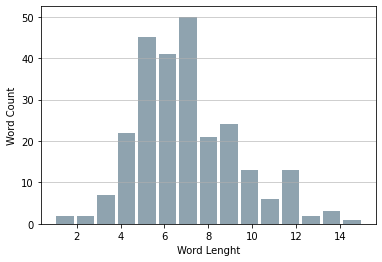

In [31]:
word_lengths = [len(w) for w in words]
plt.hist(word_lengths, bins='auto', color='#607c8e', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Word Lenght')
plt.ylabel('Word Count')
plt.show()

***Kelimelerin sayısını ve en çok kullanılan 5 kelimeyi bulalım;***

In [32]:
counter = Counter(words)
counter

Counter({'konuda': 1,
         'iş': 2,
         'sonuçlarıyla': 1,
         'hani': 2,
         'rakamlar': 1,
         'neler': 1,
         'ifade': 1,
         'sahaya': 1,
         'sorduk': 1,
         'sahadan': 1,
         'dinleyeceğiz': 1,
         'biraz': 3,
         'üretkenlik': 2,
         'içinde': 1,
         'söyleyebilirim': 1,
         'başlığı': 1,
         'temkinliydi': 1,
         'tabii': 1,
         'şirketten': 1,
         'önce': 2,
         'kısa': 1,
         'avrupa': 1,
         'ağırlık': 1,
         'evden': 1,
         'çalışma': 4,
         'dönemim': 1,
         'olmuştu': 1,
         'şahsen': 1,
         'elden': 1,
         'uygun': 1,
         'birisi': 1,
         'değilim': 1,
         'sınırları': 1,
         'çerçeveleri': 1,
         'konumları': 1,
         'seviyorum': 1,
         'ofiste': 2,
         'evdir': 1,
         'evde': 1,
         'çocuklarla': 1,
         'birlikte': 1,
         'olunur': 1,
         'yemek': 2,
         'geli

In [33]:
counter.most_common(5)

[('çalışma', 4), ('biraz', 3), ('anlamda', 3), ('sekizde', 3), ('iş', 2)]

*Yukarda yapılan işlemleri başka bir şekilde de yapabiliriz;*

In [34]:
tokens = [w for w in word_tokenize(text.lower())
                if w.isalpha()]
          
no_stops = [t for t in tokens
                if t not in my_stopwords]

Counter(no_stops).most_common(5)

[('çalışma', 4), ('biraz', 3), ('anlamda', 3), ('sekizde', 3), ('iş', 2)]

***Word Cloud oluşturalım;***

In [35]:
cloud_text = WordCloud(stopwords = stop_words, width = 500, height = 500, 
                       background_color='#40E0D0', colormap="ocean",mode="RGB").generate(text)
cloud_text

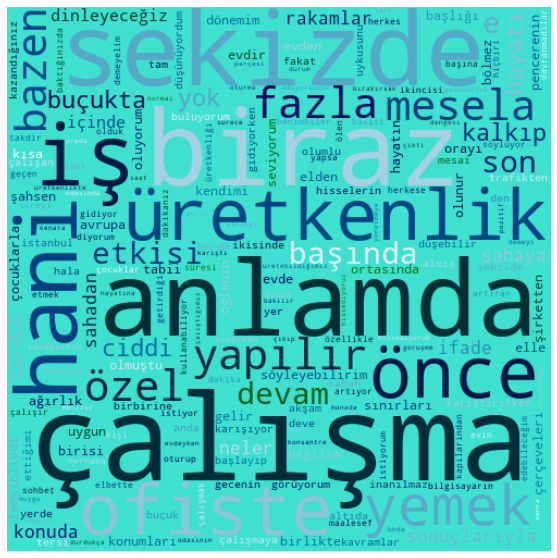

In [36]:
fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(10)
plt.imshow(cloud_text, interpolation = 'bilinear')
plt.axis('off')
plt.show()

***Maskeleme ile Word Cloud yapalım;***

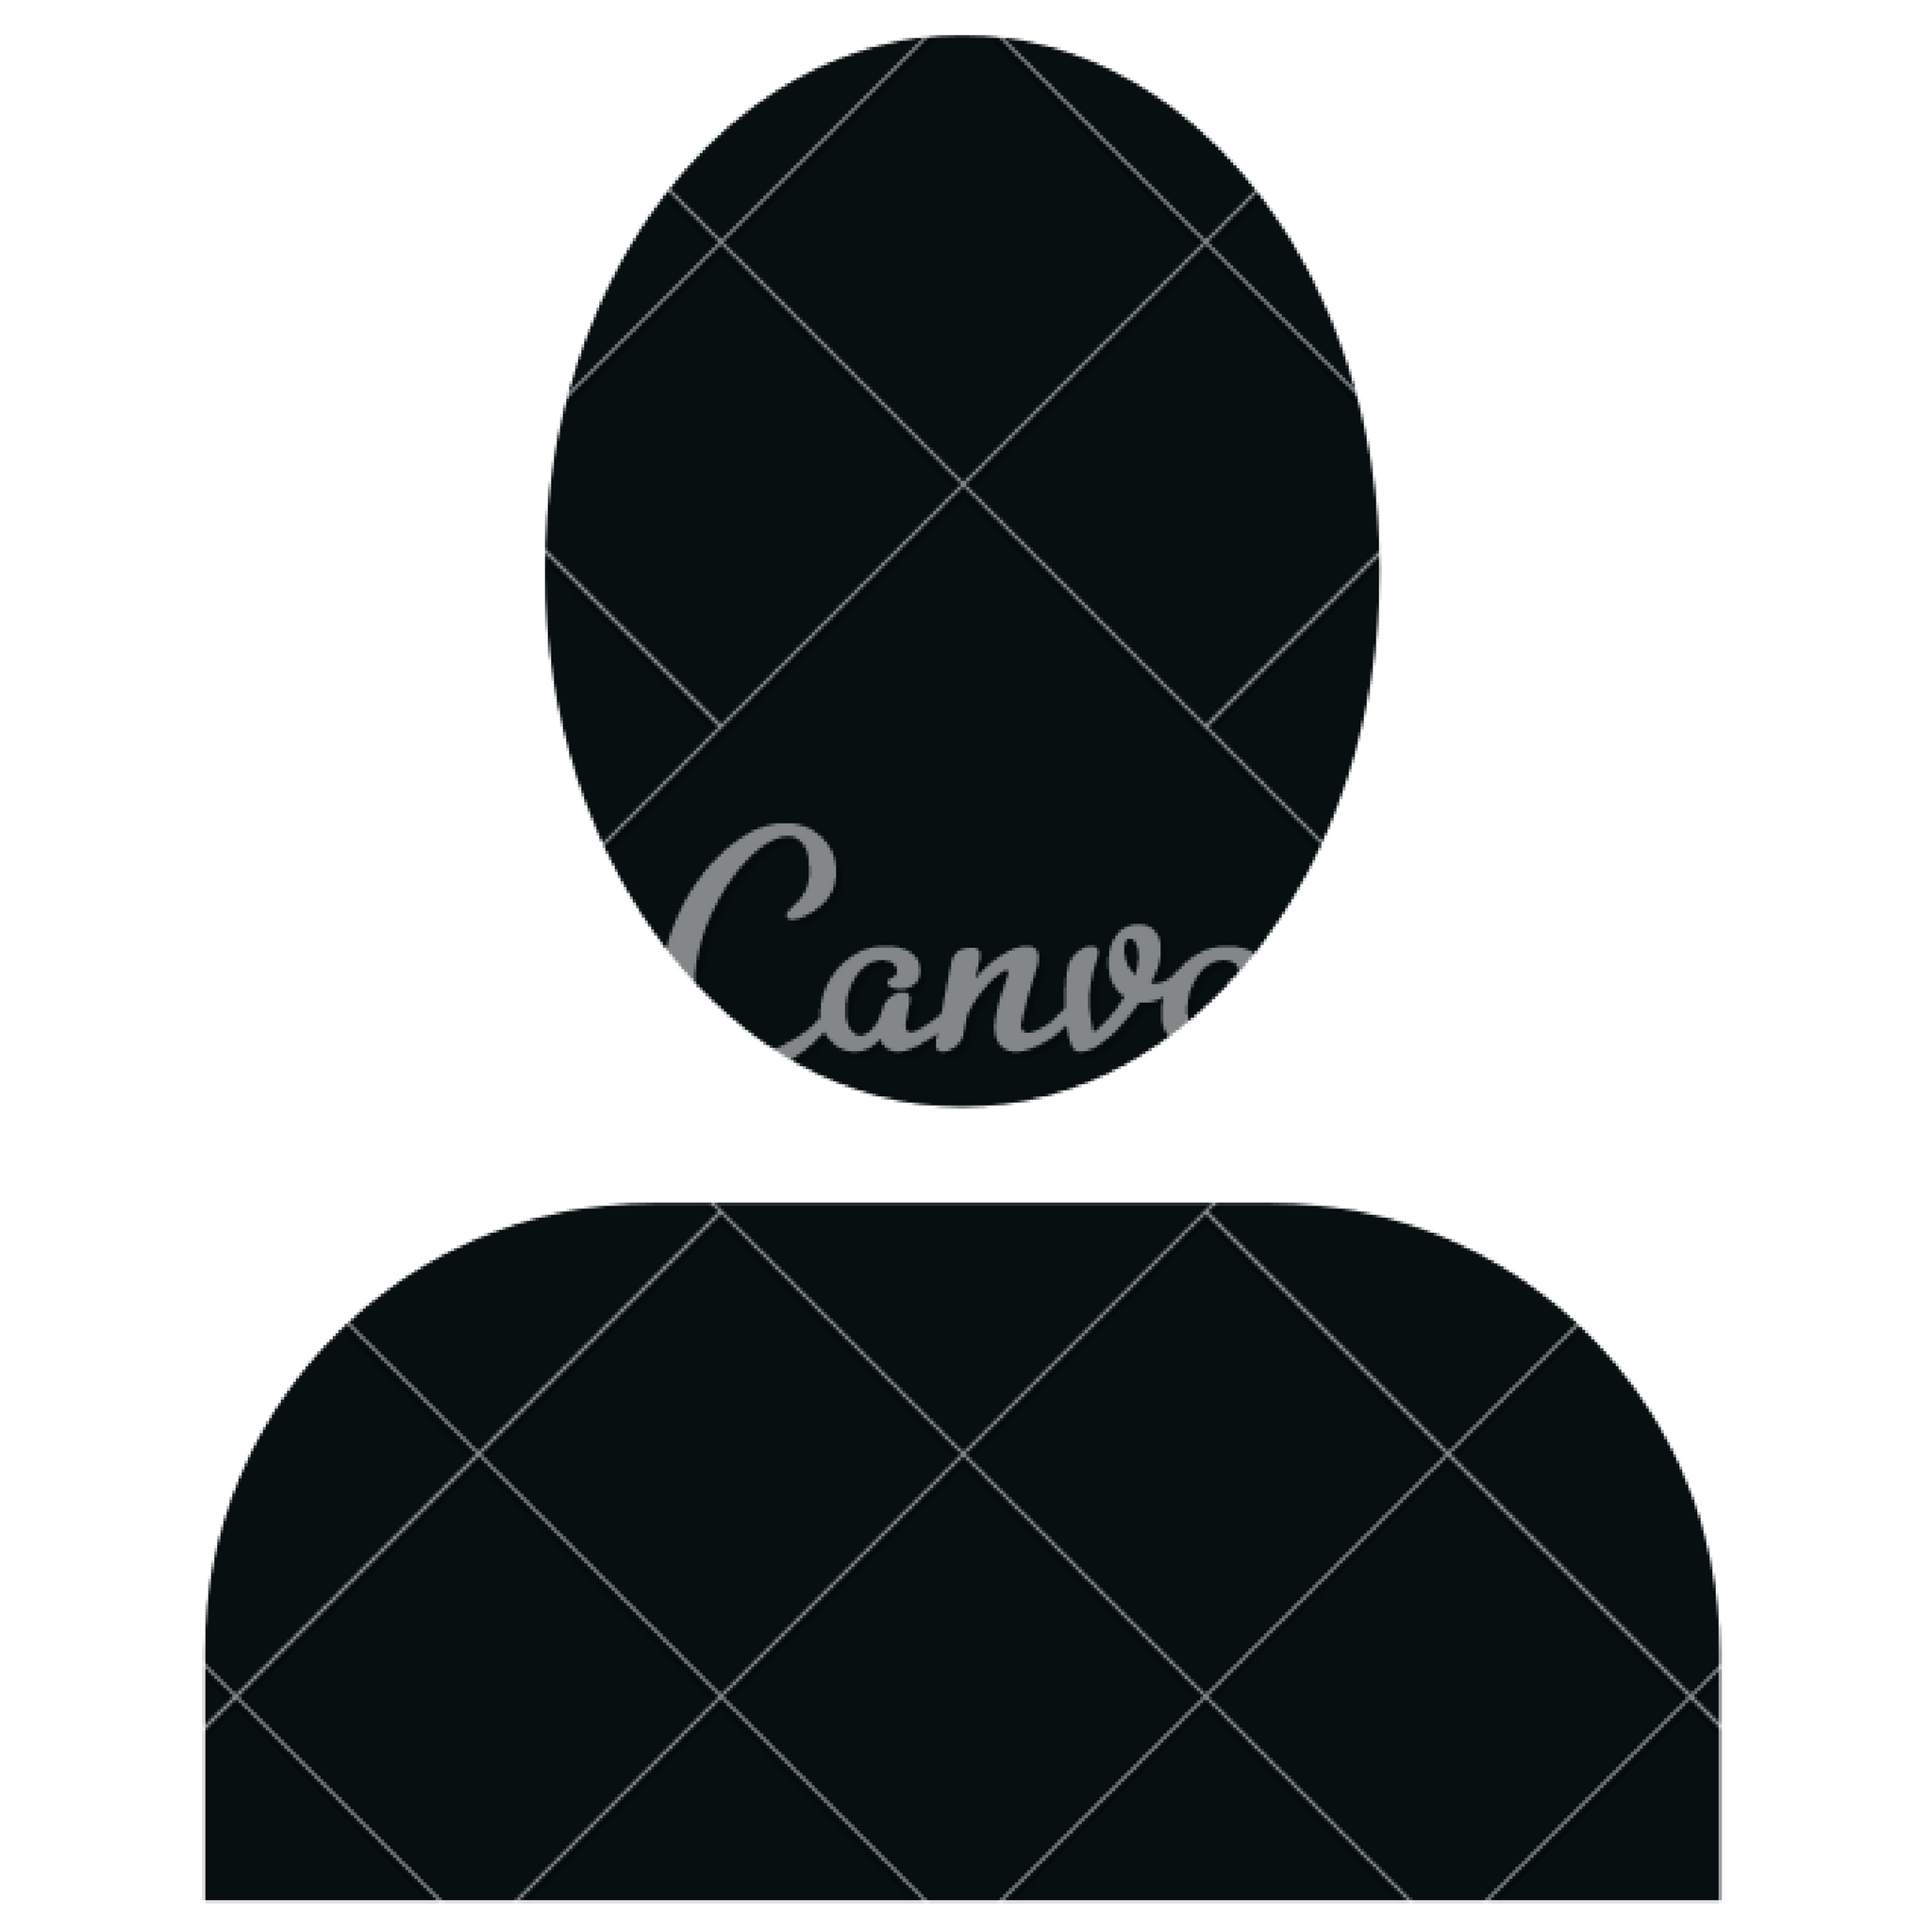

In [37]:
path="C:/Users/10011598/Sentitech/user_cagla.png"
display(Image.open(path))

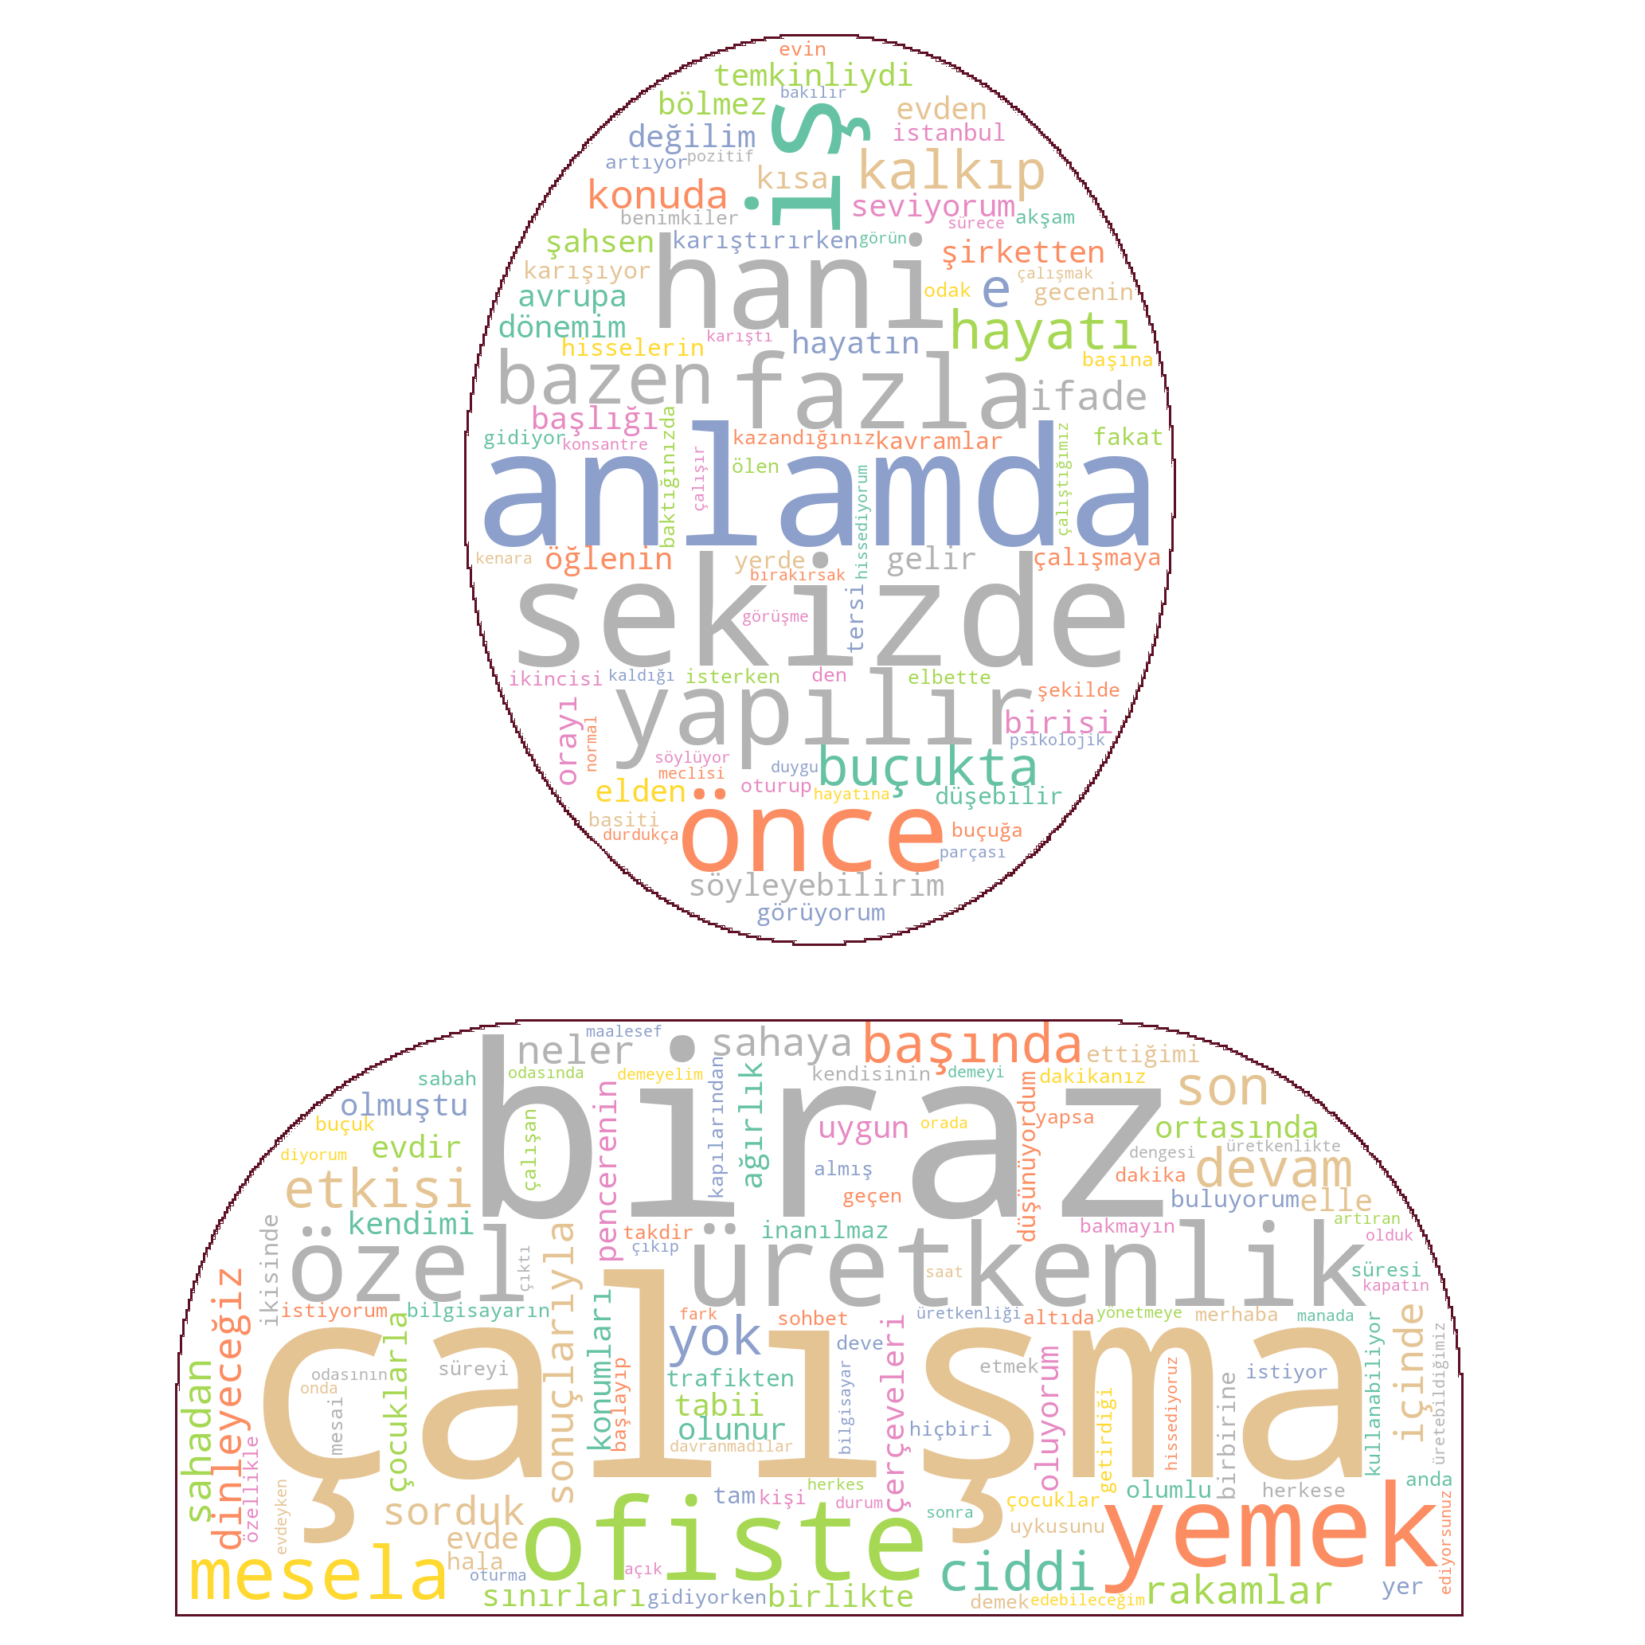

In [38]:
d5 = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
office_mask = np.array(Image.open(path))
wordcloud2 = WordCloud(
                        width = 3000, height = 2000, 
                        random_state=1, background_color='white', 
                        colormap='Set2', collocations=True, 
                        contour_width = 1, contour_color = "#5d0f24", 
                        stopwords = stop_words, mask=office_mask).generate(text)
# Plot
plt.figure(figsize=(40, 30))
plt.imshow(wordcloud2, interpolation = 'bilinear') 
plt.axis("off")
plt.show()

***Türkçe köken kontrolünü yapalım;***

In [39]:
from turkishnlp import detector
obj = detector.TurkishNLP()

In [40]:
obj.is_turkish_origin("program")

False

In [41]:
koken = [obj.is_turkish_origin(w) for w in words_list['words']]
words_list['koken'] = koken
words_list

,words,koken
0,konuda,True
1,iş,True
2,sonuçlarıyla,True
3,hani,False
4,rakamlar,True
...,...,...
247,aldığımız,True
248,araştırmayla,True
249,son,True
250,derece,True


***Text sınıflandırma işlemlerini yapalım;***

In [42]:
from transformers import pipeline, AutoModelForTokenClassification, AutoTokenizer, AutoModelForSequenceClassification
tokenizer= AutoTokenizer.from_pretrained("savasy/bert-turkish-text-classification")

# build and load model, it take time depending on your internet connection
model= AutoModelForSequenceClassification.from_pretrained("savasy/bert-turkish-text-classification")

# make pipeline
nlp1=pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# apply model
nlp1("bla bla")
# [{'label': 'LABEL_2', 'score': 0.4753005802631378}]

code_to_label={
 'LABEL_0': 'dunya ',
 'LABEL_1': 'ekonomi ',
 'LABEL_2': 'kultur ',
 'LABEL_3': 'saglik ',
 'LABEL_4': 'siyaset ',
 'LABEL_5': 'spor ',
 'LABEL_6': 'teknoloji '}

In [43]:
nlp1("Türkiye İsviçre ile oynadığı futbol maçından galip geldi")

[{'label': 'sport', 'score': 0.9447410106658936}]

In [44]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("gurkan08/bert-turkish-text-classification")
model = AutoModelForSequenceClassification.from_pretrained("gurkan08/bert-turkish-text-classification")

nlp2 = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

label_dict = {
 'LABEL_0': 'ekonomi',
 'LABEL_1': 'spor',
 'LABEL_2': 'saglik',
 'LABEL_3': 'kultur_sanat',
 'LABEL_4': 'bilim_teknoloji',
 'LABEL_5': 'egitim'}

In [45]:
nlp2("Türkiye İsviçre ile oynadığı futbol maçından galip geldi")

[{'label': 'spor', 'score': 0.27860233187675476}]

In [46]:
from transformers import pipeline, AutoModelForTokenClassification, AutoTokenizer
model = AutoModelForTokenClassification.from_pretrained("savasy/bert-base-turkish-ner-cased")
tokenizer = AutoTokenizer.from_pretrained("savasy/bert-base-turkish-ner-cased")
ner=pipeline('ner', model=model, tokenizer=tokenizer)
ner("Mustafa Kemal Atatürk 19 Mayıs 1919'da Samsun'a ayak bastı.")

[{'word': 'Mustafa',
  'score': 0.9938516616821289,
  'entity': 'B-PER',
  'index': 1,
  'start': 0,
  'end': 7},
 {'word': 'Kemal',
  'score': 0.9881671071052551,
  'entity': 'I-PER',
  'index': 2,
  'start': 8,
  'end': 13},
 {'word': 'Atatürk',
  'score': 0.9957979321479797,
  'entity': 'I-PER',
  'index': 3,
  'start': 14,
  'end': 21},
 {'word': 'Samsun',
  'score': 0.9059982299804688,
  'entity': 'B-LOC',
  'index': 9,
  'start': 39,
  'end': 45}]

In [47]:
ner("Türkiye İsviçre ile oynadığı futbol maçından galip geldi")

[{'word': 'Türkiye',
  'score': 0.8338261246681213,
  'entity': 'B-ORG',
  'index': 1,
  'start': 0,
  'end': 7},
 {'word': 'İsviçre',
  'score': 0.5075637102127075,
  'entity': 'B-LOC',
  'index': 2,
  'start': 8,
  'end': 15}]

**ÇIKARIM:** *İki farklı model denendiğinde nlp1'in daha başarılı olduğu görülmektedir.*  

***SnowBall Stemmer kullanarak kelimeleri köklerine ayıralım;***

In [48]:
from snowballstemmer import TurkishStemmer
turkStem=TurkishStemmer()
turkStem.stemWord("konuda") #konu
turkStem.stemWord("araştırmayla") #araştırma
turkStem.stemWord("sonra") #sonra

'sonra'

In [49]:
turkStem.stemWord("konuda")

'konu'

In [50]:
turkStem.stemWord("araştırmayla")

'araştırma'

In [51]:
turkStem.stemWord("sonra")

'sonra'

In [52]:
for word in words:
    print(word + ":" + turkStem.stemWord(word))

konuda:konu
iş:iş
sonuçlarıyla:sonuç
hani:hani
rakamlar:rakam
neler:ne
ifade:ifa
sahaya:saha
sorduk:sor
sahadan:saha
dinleyeceğiz:dinleyecek
biraz:biraz
üretkenlik:üretkenlik
içinde:iç
söyleyebilirim:söyleyebilir
başlığı:başlık
biraz:biraz
temkinliydi:temkinli
tabii:tabii
şirketten:şirket
önce:ö
kısa:kıs
avrupa:avrup
ağırlık:ağırlık
evden:ev
çalışma:çalışma
dönemim:döne
olmuştu:olmuş
şahsen:şah
elden:el
çalışma:çalışma
uygun:uygu
birisi:biris
değilim:değil
sınırları:sınır
çerçeveleri:çerçeve
konumları:konum
seviyorum:seviyor
ofiste:ofis
evdir:ev
evde:ev
çocuklarla:çocuk
birlikte:birlik
olunur:olunur
yemek:yemek
gelir:gelir
yemek:yemek
yapılır:yapılır
iş:iş
yapılır:yapılır
özel:özel
hayatın:hayat
fazla:faz
orayı:ora
bölmez:bölmez
elle:el
oluyorum:oluyor
mesela:mesela
bazen:baze
kendimi:kendi
öğlenin:öğle
ortasında:orta
pencerenin:pencere
başında:baş
son:son
karıştırırken:karıştırır
buluyorum:buluyor
tam:tam
tersi:tersi
gecenin:gece
ikisinde:iki
hala:hal
hisselerin:hisse
başında:baş
çalı

# Text olarak alınabilecek Kod

In [2]:
#!/usr/bin/env python3
def main():
	import sys
	import json
	import datetime
	import codecs

	filename='C:/Users/10011598/Sentitech/Audio/uzaktan_calisma_performansi_nasil_etkiliyor'
	print ("Filename: ", filename+'.json')
	with codecs.open(filename+'.txt', 'w', 'utf-8') as w:
		with codecs.open(filename+'.json', 'r', 'utf-8') as f:
			data=json.loads(f.read())
			labels = data['results']['speaker_labels']['segments']
			speaker_start_times={}
			for label in labels:
				for item in label['items']:
					speaker_start_times[item['start_time']] =item['speaker_label']
			items = data['results']['items']
			lines=[]
			line=''
			time=0
			speaker='null'
			i=0
			for item in items:
				i=i+1
				content = item['alternatives'][0]['content']
				if item.get('start_time'):
					current_speaker=speaker_start_times[item['start_time']]
				elif item['type'] == 'punctuation':
					line = line+content
				if current_speaker != speaker:
					if speaker:
						lines.append({'speaker':speaker, 'line':line, 'time':time})
					line=content
					speaker=current_speaker
					time=item['start_time']
				elif item['type'] != 'punctuation':
					line = line + ' ' + content
			lines.append({'speaker':speaker, 'line':line,'time':time})
			sorted_lines = sorted(lines,key=lambda k: float(k['time']))
          
			for line_data in sorted_lines:
				line='[' + str(datetime.timedelta(seconds=int(round(float(line_data['time']))))) + '] ' + line_data.get('speaker') + ': ' + line_data.get('line')
				w.write(line + '\n\n')


if __name__ == '__main__':
	main()

Filename:  C:/Users/10011598/Sentitech/Audio/uzaktan_calisma_performansi_nasil_etkiliyor.json


In [3]:
main()

Filename:  C:/Users/10011598/Sentitech/Audio/uzaktan_calisma_performansi_nasil_etkiliyor.json


 ### DataFrame Olarak Alınabilecek Kod İlk Yol;

In [22]:
def speaker():
    import sys
    import json
    import datetime
    import codecs

    filename='C:/Users/10011598/Sentitech/Audio/uzaktan_calisma_performansi_nasil_etkiliyor'
    #print ("Filename: ", filename+'.json')

    with codecs.open(filename+'.json', 'r', 'utf-8') as f:
        data=json.loads(f.read())
        labels = data['results']['speaker_labels']['segments']
        #print(labels)
        speaker_start_times={}
        for label in labels:
            for item in label['items']:
                speaker_start_times[item['start_time']] =item['speaker_label']
        items = data['results']['items']
        line=''
        time=0
        speaker='null'
        i=0
        lines=[]
        time1 = []
        speaker1 = []
        text1 = []
        
        #print(items)
        for item in items:
            i=i+1
            content = item['alternatives'][0]['content']
        
            if item.get('start_time'):
                current_speaker=speaker_start_times[item['start_time']]
            elif item['type'] == 'punctuation':
                line = line+content
            
            if current_speaker != speaker:
                if speaker:
                    lines.append({'speaker':speaker, 'line':line, 'time':time})
                    speaker1.append(speaker)
                    time1.append(str(datetime.timedelta(seconds=int(round(float((time)))))))
                    text1.append(line)
                    
                    
                line=content
                speaker=current_speaker
                time=item['start_time']
                
                
            elif item['type'] != 'punctuation':
                line = line + ' ' + content
                
        lines.append({'speaker':speaker, 'line':line,'time':time})
        
        speaker1.append(speaker)
        text1.append(line)
        time1.append(str(datetime.timedelta(seconds=int(round(float((time)))))))
        sorted_lines = sorted(lines,key=lambda k: float(k['time']))
        for line_data in sorted_lines:
            #print(line_data)
            line='[' + str(datetime.timedelta(seconds=int(round(float(line_data['time']))))) + '] ' + line_data.get('speaker') + ': ' + line_data.get('line')
            #print(line)
    df1=pd.DataFrame(text1,columns=['text'])
    df1['speaker']=speaker1
    df1['time'] = time1
    df1=df1.drop(index=0,axis=0)
    #print(df1.drop(index=0,axis=0))
    return df1

In [23]:
data=speaker()
data

,text,speaker,time
1,"Biz yine bu konuda, iş sonuçlarıyla ilgili han...",spk_0,0:00:04
2,üretkenlik içinde şunu söyleyebilirim başlığı ...,spk_1,0:00:20
3,dakika da olsa,spk_2,0:01:46
4,sohbet etmek istiyor. Yirmi kişi bunu yapsa kı...,spk_1,0:01:47
5,ben Üretkenlikte Meclisi veya pozitif çok cidd...,spk_2,0:02:19
6,Peki ee daha yine en doğru ee bilgi aldığımız ...,spk_0,0:03:03


 ### DataFrame Olarak Alınabilecek Kod 2. Yol

In [6]:
import tscribe
import pandas as pd
import webvtt
import json
import datetime
import time as ptime

In [7]:
tscribe.write("C:/Users/10011598/Sentitech/Audio/uzaktan_calisma_performansi_nasil_etkiliyor.json", format="csv", save_as= "C:/Users/10011598/Sentitech/transcript.csv")

C:/Users/10011598/Sentitech/transcript.csv written in 0.18 seconds.


In [8]:
df = pd.read_csv("C:/Users/10011598/Sentitech/transcript.csv");

In [9]:
df

,Unnamed: 0,start_time,end_time,speaker,comment
0,0,00:00:04,00:00:14,spk_0,"Biz yine bu konuda, iş sonuçlarıyla ilgili han..."
1,1,00:00:20,00:00:42,spk_1,üretkenlik içinde şunu söyleyebilirim başlığı ...
2,2,00:00:42,00:01:00,spk_1,"Ee işte iş yapılır, özel hayatın çok fazla ora..."
3,3,00:01:01,00:01:22,spk_1,Ee dolayısıyla ee hani bu anlamda ben mesela ü...
4,4,00:01:22,00:01:41,spk_1,şu anda çok daha uykusunu almış bir şekilde ye...
5,5,00:01:41,00:01:45,spk_1,en basiti kapılarından geçen herkese merhaba d...
6,6,00:01:45,00:01:46,spk_1,iki
7,7,00:01:46,00:01:46,spk_2,dakika da olsa
8,8,00:01:46,00:02:05,spk_1,sohbet etmek istiyor. Yirmi kişi bunu yapsa kı...
9,9,00:02:06,00:02:19,spk_1,"bir çok çalışır olduk, var yok aslında diyorum..."


In [10]:
result = df.to_json(orient="split")
parsed = json.loads(result)

dictt=[]
for i in parsed['data']:
    dictt.append({
    'speaker':i[3],
    'start_time':i[1],
    'end_time':i[2],
    'comment':i[4]
    })
dictt

[{'speaker': 'spk_0',
  'start_time': '00:00:04',
  'end_time': '00:00:14',
  'comment': 'Biz yine bu konuda, iş sonuçlarıyla ilgili hani bu rakamlar neler ifade ediyor? Yine sahaya sorduk ve Ee sahadan dinleyeceğiz. Biraz daha'},
 {'speaker': 'spk_1',
  'start_time': '00:00:20',
  'end_time': '00:00:42',
  'comment': 'üretkenlik içinde şunu söyleyebilirim başlığı biraz temkinliydi yani ben Ee tabii bu şirketten önce bir kısa Avrupa ağırlık evden çalışma dönemim olmuştu. Şahsen elden çalışma hiç uygun birisi değilim. Ee çünkü ben ee sınırları, çerçeveleri ve konumları seviyorum. Yani otuz ofiste evdir. Evde çocuklarla birlikte olunur, yemek gelir, yemek yapılır.'},
 {'speaker': 'spk_1',
  'start_time': '00:00:42',
  'end_time': '00:01:00',
  'comment': 'Ee işte iş yapılır, özel hayatın çok fazla orayı bölmez. Ben elle şey oluyorum Mesela bazen kendimi öğlenin ortasında böyle pencerenin başında son karıştırırken buluyorum. Ama tam tersi gecenin on ikisinde de hala bir hisselerin başında

In [11]:
def speaker2():
    
    index=0
    dicti=[]
    for i in dictt:
        temp={}
        try:
            if index==0:
                #print("index=0 durumu")
                dicti.append(dictt[index])

            elif dictt[index]['speaker']!=dictt[index-1]['speaker']:
                #print("bir önceki farklı ise  speakerlar")
                dicti.append({
                        'speaker': dictt[index]['speaker'],
                        'start_time':dictt[index]['start_time'],
                        'end_time':dictt[index]['end_time'],
                        'comment':dictt[index]['comment']
                })

            else:
                #print("bir önceki ile aynıı")
                try:
                    newindex=len(dicti)-1
                    """
                    temp={
                        'speaker': dictt[index]['speaker'],
                        'start_time':dictt[index-1]['start_time'],
                        'end_time':dictt[index]['end_time'],
                        'comment':dictt[index-1]['comment']+'.'+dictt[index]['comment']
                    }
                    """
                    dicti[newindex]['speaker']=dictt[index]['speaker']
                    dicti[newindex]['start_time']=dicti[newindex]['start_time']
                    dicti[newindex]['end_time']=dictt[index]['end_time']
                    dicti[newindex]['comment']=dicti[newindex]['comment']+"."+dictt[index]['comment']
                except IndexError as e:
                    #print("hataverdi")
                    dicti.append(temp)
        except IndexError as e:
            print(e)
        #print("index arttırma öncesi")
        #print(index)
        index+=1
    a = pd.DataFrame.from_dict(dicti)
    return a

In [12]:
data = speaker2()
data

,speaker,start_time,end_time,comment
0,spk_0,00:00:04,00:00:14,"Biz yine bu konuda, iş sonuçlarıyla ilgili han..."
1,spk_1,00:00:20,00:01:46,üretkenlik içinde şunu söyleyebilirim başlığı ...
2,spk_2,00:01:46,00:01:46,dakika da olsa
3,spk_1,00:01:46,00:02:19,sohbet etmek istiyor. Yirmi kişi bunu yapsa kı...
4,spk_2,00:02:19,00:02:59,ben Üretkenlikte Meclisi veya pozitif çok cidd...
5,spk_0,00:03:02,00:03:09,Peki ee daha yine en doğru ee bilgi aldığımız ...


## Sentiment Analysis

In [14]:
## Turkish Bert Pipeline
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline

model = AutoModelForSequenceClassification.from_pretrained("savasy/bert-base-turkish-sentiment-cased")
tokenizer = AutoTokenizer.from_pretrained("savasy/bert-base-turkish-sentiment-cased")
sa= pipeline("sentiment-analysis", tokenizer=tokenizer, model=model)

In [15]:
sentiment = []
score = []
for i in data['comment']:
    sentiment.append(sa(i)[0]['label'])
    score.append(sa(i)[0]['score'])
data['sentiment']=sentiment
data['score']=score

In [16]:
data

,speaker,start_time,end_time,comment,sentiment,score
0,spk_0,00:00:04,00:00:14,"Biz yine bu konuda, iş sonuçlarıyla ilgili han...",negative,0.948679
1,spk_1,00:00:20,00:01:46,üretkenlik içinde şunu söyleyebilirim başlığı ...,positive,0.845118
2,spk_2,00:01:46,00:01:46,dakika da olsa,negative,0.960027
3,spk_1,00:01:46,00:02:19,sohbet etmek istiyor. Yirmi kişi bunu yapsa kı...,positive,0.955773
4,spk_2,00:02:19,00:02:59,ben Üretkenlikte Meclisi veya pozitif çok cidd...,negative,0.997754
5,spk_0,00:03:02,00:03:09,Peki ee daha yine en doğru ee bilgi aldığımız ...,positive,0.995301


Konuşmacıların sentiment analizi

In [17]:
speaker_score = data['sentiment'].groupby(data['speaker'])
print(speaker_score.max())

speaker
spk_0    positive
spk_1    positive
spk_2    negative
Name: sentiment, dtype: object


In [18]:
def pos_neg_notr():
    pos_val = 0
    neg_val = 0
    notr_val = 0
    
    for sent in data['sentiment']:
        if sent =='positive':
            pos_val += 1
            #print(pos_val)
        elif sent =='negative':
            neg_val += 1
            #print(neg_val)
        else:
            notr_val +1
    count = [pos_val, neg_val, notr_val]
    count = pd.DataFrame(list(count))
    count.index =['pos_val', 'neg_val', 'notr_val']
    count.columns = ['count']
    return count

In [19]:
test = pos_neg_notr()
test

,count
pos_val,3
neg_val,3
notr_val,0


In [26]:
data['text']

1    Biz yine bu konuda, iş sonuçlarıyla ilgili han...
2    üretkenlik içinde şunu söyleyebilirim başlığı ...
3                                       dakika da olsa
4    sohbet etmek istiyor. Yirmi kişi bunu yapsa kı...
5    ben Üretkenlikte Meclisi veya pozitif çok cidd...
6    Peki ee daha yine en doğru ee bilgi aldığımız ...
Name: text, dtype: object

In [ ]:
import re

In [98]:
a = data['text'][1]

list_ = ['?' , '!', '...']

for i in list_:
    a = a.replace(i, '.')
    

a
a = a.split('.')
a

['Biz yine bu konuda, iş sonuçlarıyla ilgili hani bu rakamlar neler ifade ediyor',
 ' Yine sahaya sorduk ve Ee sahadan dinleyeceğiz',
 ' Biraz daha']

In [41]:
data['text'][2]

'Evet, böyle olur. Gazetemizin. Evet, benim ama yani adı Erdoğan olan Tek bakalım. Ben değilimdir ama bakalım adımlarla koyacak tekrarlamayacağız olabilir de. Benim yazım değil. Anne şimdi bir yasa mı bu yani kimse Ben şey yapmak istemem yani günahını almak istemem de Bizim bir yavuz var. Hırsız Aydoğdu. Yani sağlam ayakkabı değil yani. Bir ona bakın derim ben. Çünkü bugün hırsızlık yapan yarın anlamda öldürebilirdi, mi.'

In [34]:
datapath = r'C:\Users\10011598\Desktop\Big Data Community\output.csv'
data = pd.read_csv(datapath, delimiter=',')

In [49]:
#data = data.reset_index(drop=True)

datapath = r'C:\Users\10011598\Desktop\Big Data Community\output.csv'
data = pd.read_csv(datapath)

list_ = ['?' , '!', '...']
df = pd.DataFrame(columns = ['text', 'speaker', 'time'])
j = 0

for i in range(len(data['text'])):
    temp = data['speaker'][i]
    temp2 = data['time'][i]
    temp3 = data['text'][i]
    for k in list_:
        temp3 = temp3.replace(k, '.')
    split_text = temp3.split('.')

    #print(temp3)
    
    #print(split_text)

    for split in (split_text):
        
        
        #df = df.append({'text': j}, ignore_index=True)
       # df = df.append({'speaker': temp}, ignore_index=True)
        #df = df.append({'time': temp2}, ignore_index=True)
        if split!='':
            
            df.loc[j] = split , temp ,temp2
            j += 1

df

,text,speaker,time
0,"bak,",spk_0,0:00:04
1,iyi bakla,spk_1,0:00:05
2,Buna Medine evinde bulduk,spk_1,0:00:05
3,Bak bu Kraken üstünde sizin isimleriniz,spk_1,0:00:05
4,Yazılılar,spk_1,0:00:05
5,"Evet, böyle olur",spk_0,0:00:13
6,Gazetemizin,spk_0,0:00:13
7,"Evet, benim ama yani adı Erdoğan olan Tek bak...",spk_0,0:00:13
8,Ben değilimdir ama bakalım adımlarla koyacak ...,spk_0,0:00:13
9,Benim yazım değil,spk_0,0:00:13


In [55]:
def splited_dataframe(csv_file):
    
    list_ = ['?' , '!', '...']
    df = pd.DataFrame(columns = ['text', 'speaker', 'time'])
    j = 0

    for i in range(len(data['text'])):
        temp = data['speaker'][i]
        temp2 = data['time'][i]
        temp3 = data['text'][i]
        for k in list_:
            temp3 = temp3.replace(k, '.')
        split_text = temp3.split('.')


        for split in (split_text):

            if split!='':

                df.loc[j] = split , temp ,temp2
                j += 1
    
    return df 

In [54]:
af = splited_dataframe(data)
af

,text,speaker,time
0,"bak,",spk_0,0:00:04
1,iyi bakla,spk_1,0:00:05
2,Buna Medine evinde bulduk,spk_1,0:00:05
3,Bak bu Kraken üstünde sizin isimleriniz,spk_1,0:00:05
4,Yazılılar,spk_1,0:00:05
5,"Evet, böyle olur",spk_0,0:00:13
6,Gazetemizin,spk_0,0:00:13
7,"Evet, benim ama yani adı Erdoğan olan Tek bak...",spk_0,0:00:13
8,Ben değilimdir ama bakalım adımlarla koyacak ...,spk_0,0:00:13
9,Benim yazım değil,spk_0,0:00:13


In [56]:
def sentimented_dataframe(data):
    sentiment = []
    score = []
    for i in df['text']:
        sentiment.append(sa(i)[0]['label'])
        score.append(sa(i)[0]['score'])
    df['sentiment']=sentiment
    df['score']=score
    
    return df

In [57]:
sentimented_dataframe(af)

,text,speaker,time,sentiment,score
0,"bak,",spk_0,0:00:04,positive,0.964313
1,iyi bakla,spk_1,0:00:05,positive,0.795696
2,Buna Medine evinde bulduk,spk_1,0:00:05,negative,0.988417
3,Bak bu Kraken üstünde sizin isimleriniz,spk_1,0:00:05,positive,0.992242
4,Yazılılar,spk_1,0:00:05,positive,0.816322
5,"Evet, böyle olur",spk_0,0:00:13,positive,0.987905
6,Gazetemizin,spk_0,0:00:13,positive,0.534523
7,"Evet, benim ama yani adı Erdoğan olan Tek bak...",spk_0,0:00:13,negative,0.916999
8,Ben değilimdir ama bakalım adımlarla koyacak ...,spk_0,0:00:13,positive,0.837542
9,Benim yazım değil,spk_0,0:00:13,negative,0.989286


In [29]:
sentiment = []
score = []
for i in df['text']:
    sentiment.append(sa(i)[0]['label'])
    score.append(sa(i)[0]['score'])
df['sentiment']=sentiment
df['score']=score
df

,text,speaker,time,sentiment,score
0,"Biz yine bu konuda, iş sonuçlarıyla ilgili han...",spk_0,0:00:04,negative,0.887482
1,Yine sahaya sorduk ve Ee sahadan dinleyeceğiz,spk_0,0:00:04,positive,0.948009
2,Biraz daha,spk_0,0:00:04,negative,0.959870
3,üretkenlik içinde şunu söyleyebilirim başlığı ...,spk_1,0:00:20,negative,0.785425
4,Şahsen elden çalışma hiç uygun birisi değilim,spk_1,0:00:20,negative,0.997590
5,"Ee çünkü ben ee sınırları, çerçeveleri ve kon...",spk_1,0:00:20,positive,0.997095
6,Yani otuz ofiste evdir,spk_1,0:00:20,positive,0.512738
7,"Evde çocuklarla birlikte olunur, yemek gelir,...",spk_1,0:00:20,positive,0.902999
8,"Ee işte iş yapılır, özel hayatın çok fazla or...",spk_1,0:00:20,positive,0.873728
9,Ben elle şey oluyorum Mesela bazen kendimi öğ...,spk_1,0:00:20,negative,0.710541


In [163]:
#data = data.drop(columns=['index'])
data['text'][1]

'üretkenlik içinde şunu söyleyebilirim başlığı biraz temkinliydi yani ben Ee tabii bu şirketten önce bir kısa Avrupa ağırlık evden çalışma dönemim olmuştu. Şahsen elden çalışma hiç uygun birisi değilim. Ee çünkü ben ee sınırları, çerçeveleri ve konumları seviyorum. Yani otuz ofiste evdir. Evde çocuklarla birlikte olunur, yemek gelir, yemek yapılır. Ee işte iş yapılır, özel hayatın çok fazla orayı bölmez. Ben elle şey oluyorum Mesela bazen kendimi öğlenin ortasında böyle pencerenin başında son karıştırırken buluyorum. Ama tam tersi gecenin on ikisinde de hala bir hisselerin başında çalışmaya devam ettiğimi de görüyorum. Çünkü kavramlar birbirine karışıyor. Ee dolayısıyla ee hani bu anlamda ben mesela üretkenlik düşebilir diye düşünüyordum. Fakat inanılmaz olumlu etkisi oldu. E çünkü bir yer Istanbul gibi bir yerde trafikten kazandığınız, yani sekizde başlayıp altıda bir den mesai için çalışan, daha önce sabah altı altı buçukta kalkıp akşam yedi yedi buçuk deve gidiyorken şu anda çok dah

In [132]:
sent_tokens

['Biz yine bu konuda, iş sonuçlarıyla ilgili hani bu rakamlar neler ifade ediyor?',
 'Yine sahaya sorduk ve Ee sahadan dinleyeceğiz.',
 'Biraz daha üretkenlik içinde şunu söyleyebilirim başlığı biraz temkinliydi yani ben Ee tabii bu şirketten önce bir kısa Avrupa ağırlık evden çalışma dönemim olmuştu.',
 'Şahsen elden çalışma hiç uygun birisi değilim.',
 'Ee çünkü ben ee sınırları, çerçeveleri ve konumları seviyorum.',
 'Yani otuz ofiste evdir.',
 'Evde çocuklarla birlikte olunur, yemek gelir, yemek yapılır.',
 'Ee işte iş yapılır, özel hayatın çok fazla orayı bölmez.',
 'Ben elle şey oluyorum Mesela bazen kendimi öğlenin ortasında böyle pencerenin başında son karıştırırken buluyorum.',
 'Ama tam tersi gecenin on ikisinde de hala bir hisselerin başında çalışmaya devam ettiğimi de görüyorum.',
 'Çünkü kavramlar birbirine karışıyor.',
 'Ee dolayısıyla ee hani bu anlamda ben mesela üretkenlik düşebilir diye düşünüyordum.',
 'Fakat inanılmaz olumlu etkisi oldu.',
 'E çünkü bir yer Istanbul

In [136]:
type(transcript_text)

pandas.core.series.Series

In [ ]:
list_ = ['?' , '!', '...']
df = pd.DataFrame(columns = ['text', 'speaker', 'time'])


for i, text in enumerate(data['text']):
    temp = data['speaker'][i]
    temp2 = data['time'][i]
    for k in list_:
        text = text.replace(k, '.')
    split_text = text.split('.')

   
    
    for j, split in enumerate(sent_tokens):
        
        
        #df = df.append({'text': j}, ignore_index=True)
       # df = df.append({'speaker': temp}, ignore_index=True)
        #df = df.append({'time': temp2}, ignore_index=True)

        df.loc[j] = split , temp ,temp2


df